In [22]:
import numpy as np
import matplotlib.pyplot as plt
from beam_mechanics_3_script import simulate_beam, jacobian_tip_from_sim2, m_line_of_s
from constants import *

Although this implmentation is quasi static, we define A and B matrices for implementation. 

In [23]:
def seq_mat(A, B, N):
    n, m = A.shape[0], B.shape[1]
    M = np.zeros((N*n,n))
    C = np.zeros((N*n, N*m))
    A_pow = np.eye(n)

    for i in range(1, N+1):
        A_pow = A@A_pow
        M[(i-1)*n:i*n,:] = A_pow
        
        for j in range(i):
            C[(i-1)*n: i*n, j*m:(j+1)*m] = np.linalg.matrix_power(A, i-1-j)@B
    return M,C 

Function for the block diagonal

In [24]:
def diag_bl(mat, times):
    r,c = mat.shape
    out = np.zeros((times*r, times*c))
    for i in range(times):
        out[i*r:(i+1)*r, i*c:(i+1)*c] = mat
    return out
    

Now build the mpc H and f matrices for quadratic programming

In [ ]:
def mpc_setup(A, B, Q, R, B_th, Qf, N, xk, xref_seq=None):
    n, m = A.shape[0], B.shape[1]
    M, C = seq_mat(A,B,N)

    Qtil = diag_bl(Q, N-1)

    Qtil = np.block([
        [Qtil, np.zeros(((N-1)*n,n))],
        [np.zeros((n, (N-1)*n)), Qf]
    ])

    Rtil = diag_bl(R, N)
    if xref_seq is None:
        Rvec = np.zeros(N*n)
    else:
        Rvec = xref_seq.reshape(N*n)


    H = 2*(C.T@Qtil@C+Rtil)
    F = 2*  C.T@Qtil@(M@xk-Rvec)

    try:
        U_star = -np.linalg.solve(H,F)
    except np.linalg.LinAlgError:
        U_star = -np.linalg.lstsq(H,F, rcond=None)[0]
    X_pred = M@xk+C@U_star
    u0 = U_star[:m]
    E = np.linalg.solve(H, 2 * (C.T @ Qtil))          # shape: (N*m) x (N*n)
    L = float(-(E[0, :] @ M))                          # shape: (1 x n) -> scalar for n=1
    lam_cl = 1.0 + float(B_th[0,0]) * L               # eigenvalue of A + B L (since A=1)
    print(f"L={L:+.6f},  lambda_cl={lam_cl:+.6f}")


    return u0, U_star, X_pred, H, F, M, C, Qtil

    


In [ ]:
# def mpc_setup(A, B, Q, R, Qf, N, xk, xref_seq=None):
#     n, m = A.shape[0], B.shape[1]
#     M, C = seq_mat(A,B,N)

#     Qtil = diag_bl(Q, N-1)

#     Qtil = np.block([
#         [Qtil, np.zeros(((N-1)*n,n))],
#         [np.zeros((n, (N-1)*n)), Qf]
#     ])

#     Rtil = diag_bl(R, N)
#     if xref_seq is None:
#         Rvec = np.zeros(N*n)
#     else:
#         Rvec = xref_seq.reshape(N*n)


#     # exact predicted tracking (unconstrained, scalar integrator)
#     d = Rvec - (M @ xk)          # shape [N]
#     U_star = np.linalg.solve(C, d)  # since C = b*S is lower-triangular and invertible
#     X_pred = M @ xk + C @ U_star
#     u0 = U_star[:B.shape[1]]
#     H, F = None, None  # not used in this mode
#     return u0, U_star, X_pred, H, F, M, C, Qtil


    


The main MPC function will be implemented below. This function will be simple and provide a base MPC

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def print_rollout_table(k, t, dt, psi_k, u_star, S, theta_pred, R_vec):
    u_deg_s       = np.degrees(u_star)
    dpsi_deg      = np.degrees(S @ u_star)                 # cumulative Δψ
    psi_pred_deg  = np.degrees(psi_k + S @ u_star)
    theta_pred_deg= np.degrees(theta_pred)
    R_deg         = np.degrees(R_vec)
    err_deg       = theta_pred_deg - R_deg

    header = (f"\n[Rollout] k={k}  t={t:.3f}s  ψ_k={np.degrees(psi_k):+.2f}°  "
              f"max|Δψ|={np.max(np.abs(dpsi_deg)):.2f}°  max|θ̂-R|={np.max(np.abs(err_deg)):.2f}°")
    print(header)
    print(" i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]")
    print("-"*86)
    for i in range(len(u_star)):
        print(f"{i+1:2d} | {u_deg_s[i]:+12.2f} | {dpsi_deg[i]:+12.2f} |"
              f" {psi_pred_deg[i]:+11.2f} | {theta_pred_deg[i]:+11.2f} |"
              f" {R_deg[i]:+11.2f} | {err_deg[i]:+13.2f}")

In [226]:
def simple_mpc(ref, T, dt, p_vec, *, Np = 15, w_th=1.0, w_u=1e-3, psi0_rad=0.0, J_min=1e-5, s_steps=200):
    
    t_hist, th_hist, thref_hist, psi_hist, u_hist, J_hist = [], [], [], [], [], []
    pred_theta_hist_deg, pred_psi_hist_deg = [], []
    pred_ref_hist_deg,   pred_u_hist_deg_s = [], []
    e1_hist_deg = []
    psi = psi0_rad


    N = int(T/dt)
    for k in range(N):
        t = k*dt
        theta0,_,_,_ = simulate_beam(p_vec, np.rad2deg(psi), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val)
        theta_tip, J0, pack = jacobian_tip_from_sim2(
            p_vec, psi,
            L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M,
            m_line_of_s=m_line_of_s,
            GRAD_SCALE=1.0, s_steps=400
        )
    # inside simple_mpc, just before building B_th
        b = J0 if abs(J0) >= J_min else (np.sign(J0) if J0 != 0 else 1.0) * J_min
        B_th = np.array([[b * dt]])   # replaces B_th = np.array([[J0*dt]])

        R_vec = np.array([ref(t+(i+1)*dt)[0] for i in range(Np)],dtype=float)
        A_th = np.array([[1.0]])
        B_th = np.array([[J0*dt]])
        Q_th = np.array([[w_th]])
        R_u = np.array([[w_u]])
        Qf_th = Q_th

        xk_th = np.array([theta0])
        xref_seq = R_vec.reshape(Np,1)

        u0, U_star, X_pred, H, F, M, C, Qtil = mpc_setup(A_th, B_th, Q_th, R_u, B_th, Qf_th, Np, xk_th, xref_seq)
        # assert np.allclose(X_pred.reshape(Np), R_vec, atol=1e-10), "Predicted != reference"

        u_apply = float(u0)
        psi_next = psi + u_apply*dt

        theta_pred = X_pred.reshape(Np)
        theta_next,_,_,_ = simulate_beam(p_vec, np.rad2deg(psi_next), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val)
        e1_hist_deg.append(np.degrees(theta_next-theta_pred[0]))

        S = np.tril(np.ones((Np, Np), float)) * dt
        psi_pred = psi + S @ U_star.reshape(-1)
        print_rollout_table(k, t, dt, psi, U_star.reshape(-1), S, theta_pred, R_vec)
        # print(
        # # f"step={k} | J0={J0:.3e} | ||H||={np.linalg.norm(H):.3e} "
        # f"| ||F||={np.linalg.norm(F):.3e} | ||U*||={np.linalg.norm(U_star):.3e}"
        # )
        lam_min = np.linalg.eigvalsh(C.T @ Qtil @ C).min()
        rho = w_u / lam_min
        print(f"lam_min(C^T Q C)={lam_min:.2e}  rho={rho:.2e}")

        pred_theta_hist_deg.append(np.degrees(theta_pred))
        pred_psi_hist_deg.append(np.degrees(psi_pred))
        pred_ref_hist_deg.append(np.degrees(R_vec))
        pred_u_hist_deg_s.append(np.degrees(U_star.reshape(-1)))

        psi = psi_next

        t_hist.append(t)
        th_hist.append(theta0)
        thref_hist.append(ref(t)[0]) 
        psi_hist.append(psi)
        u_hist.append(u_apply)
        J_hist.append(J0)
    t    = np.array(t_hist)
    th   = np.degrees(np.array(th_hist))
    thR  = np.degrees(np.array(thref_hist))
    psiA = np.degrees(np.array(psi_hist))
    uA   = np.degrees(np.array(u_hist))
    Jarr = np.array(J_hist)
    e1d  = np.array(e1_hist_deg)
    rmse1_deg = float(np.sqrt(np.mean(e1d**2))) if len(e1d) else float("nan")
    
    return dict(
    t=t, theta_deg=th, theta_ref_deg=thR, psi_deg=psiA, u_deg_s=uA, J=Jarr,
    pred_theta_deg=np.array(pred_theta_hist_deg),
    pred_psi_deg=np.array(pred_psi_hist_deg),
    pred_ref_deg=np.array(pred_ref_hist_deg),
    pred_u_deg_s=np.array(pred_u_hist_deg_s),
    e1_deg=e1d, rmse1_deg=rmse1_deg, Np=Np, dt=dt
)     



In [28]:
def make_ref_sine(Amp, freq, offset, phase):
    w = 2*np.pi*freq
    return lambda t:(offset + Amp*-1*np.sin(w*t+phase), Amp*w*np.cos(w*t+phase)) 

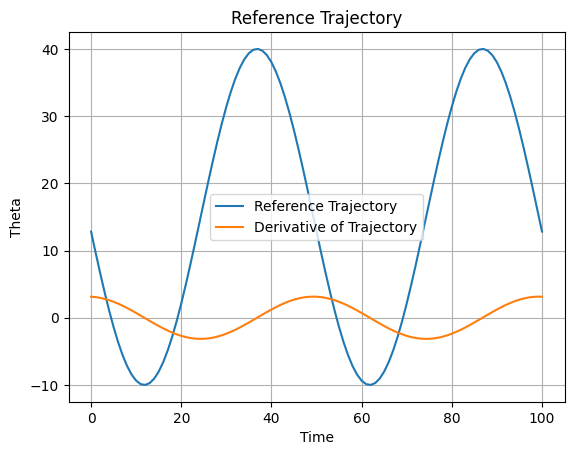

In [29]:
amp = np.deg2rad(25)
freq = 0.02
offset = np.deg2rad(15)
phase = np.deg2rad(5)
time = 100
dt = 1
ref = make_ref_sine(amp, freq, offset, phase)

t = np.arange(0.0, time+dt, dt)
theta = np.array([ref(test)[0] for test in t])
theta_dot = np.array([ref(test)[1] for test in t])


plt.figure()
plt.plot(t, np.rad2deg(theta), label="Reference Trajectory")
plt.plot(t, np.rad2deg(theta_dot), label="Derivative of Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Reference Trajectory")
plt.legend()
plt.grid()
plt.show()

In [208]:
psi_vals_deg = np.linspace(-90, 90, 20)
psi_vals_rad = np.deg2rad(psi_vals_deg)

ys = np.array([0.2])
theta_vs_psi = {py: [] for py in ys}
dtheta_dpsi_vs_psi = {py: [] for py in ys}
psi_done = {py: [] for py in ys}

for p_y in ys:
    p_vec = np.array([0, p_y, 0.0], float)
    for psi_deg in psi_vals_deg:
        try:
            theta_tip, k_star, sol_ivp, info = simulate_beam(
                p_vec=p_vec,
                psi_deg=psi_deg,
                L=LENGTH,
                A_val=A_val,  
                E_val=E_val,
                I_val=I_val,
                MU0=MU0,
                MAGNET_M=MAGNET_M,
                m_line_of_s=m_line_of_s,
                s_steps=200
            )
        except Exception as e:
            print(f"[WARN] skipped p_y={p_y}, psi={psi_deg:.1f}: {e}")
            continue

        theta_vs_psi[p_y].append(np.degrees(theta_tip))
        psi_done[p_y].append(psi_deg)

    print(f"p_y={p_y}: filled {len(psi_done[p_y])}/{len(psi_vals_deg)} points")



p_y=0.2: filled 20/20 points


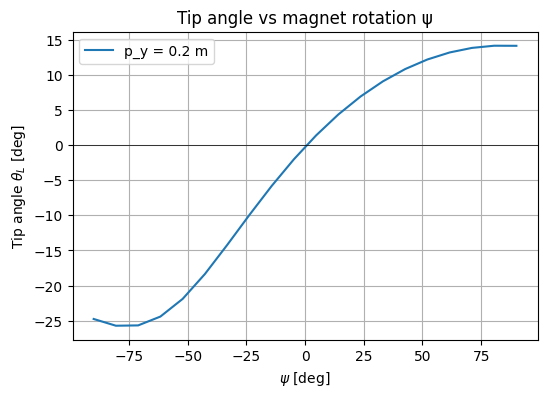

In [210]:
plt.figure(figsize=(6,4))
for p_y in ys:
    plt.plot(psi_vals_deg, theta_vs_psi[p_y], label=f"p_y = {p_y} m")
plt.axhline(0, color='k', lw=0.5)
plt.xlabel(r"$\psi$ [deg]")
plt.ylabel(r"Tip angle $\theta_L$ [deg]")
plt.legend()
plt.title("Tip angle vs magnet rotation ψ")
plt.grid(True)
plt.show()


In [33]:

# psi_vals_deg = np.linspace(-90, 90, 20)
psi_vals_rad = np.linspace(-3,3,20)
# ys = np.array([0.18])   
ys = np.array([0.18])

theta_vs_psi = {py: [] for py in ys}
dtheta_dpsi_vs_psi = {py: [] for py in ys}
psi_done = {py: [] for py in ys}
packs = {py: [] for py in ys} 

for p_y in ys:
    p_vec = np.array([0.0, p_y, 0.0], float)
    for psi_rad in psi_vals_rad:
        try:
            theta_tip, J_tip, pack = jacobian_tip_from_sim2(
                p_vec, psi_rad,
                L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
                MU0=MU0, MAGNET_M=MAGNET_M,
                m_line_of_s=m_line_of_s,
                GRAD_SCALE=1.0, s_steps=400
            )
        except Exception as e:
            print(f"[WARN] skipped p_y={p_y}, psi={psi_rad:.1f}: {e}")
            continue

        theta_vs_psi[p_y].append(np.degrees(theta_tip))
        dtheta_dpsi_vs_psi[p_y].append(J_tip)            
        psi_done[p_y].append(psi_rad)
        packs[p_y].append(pack)

    print(f"p_y={p_y}: filled {len(psi_done[p_y])}/{len(psi_vals_rad)} points")


p_y=0.18: filled 20/20 points


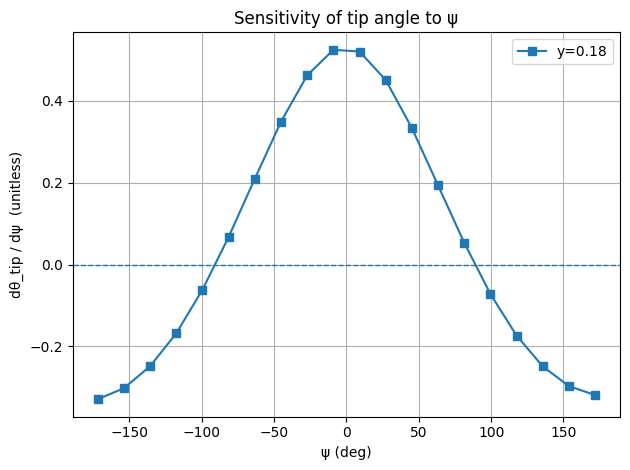

In [35]:
plt.figure()
for p_y in ys:                         
    ps = np.array(psi_done[p_y])
    J  = np.array(dtheta_dpsi_vs_psi[p_y])
    order = np.argsort(ps)
    plt.plot(np.degrees(ps[order]),          
             J[order], marker='s', label=f"y={p_y:.2f}")
plt.axhline(0, linestyle='--', linewidth=1)
plt.xlabel("ψ (deg)")                    
plt.ylabel("dθ_tip / dψ  (unitless)")
plt.title("Sensitivity of tip angle to ψ")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


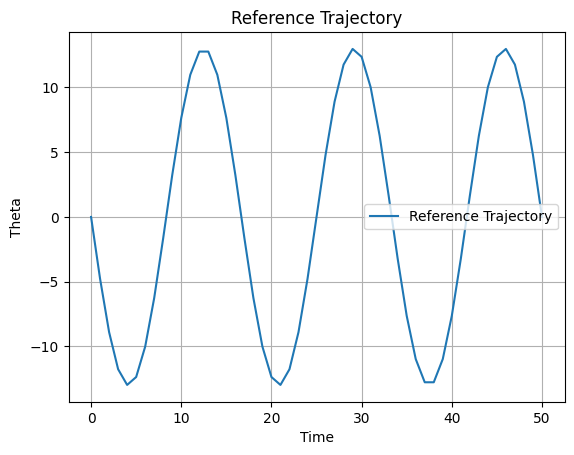

In [233]:
p_vec = np.array([0.0, 0.2, 0.0])
A_deg = np.deg2rad(13)      
f_hz = 0.06   
offset_deg = np.deg2rad(0.0)  
phase_deg = 0.0  
time = 50.0          
dt = 1     
Np = 3   
ref = make_ref_sine(A_deg, f_hz, offset_deg, phase_deg)
t = np.arange(0.0, time+dt, dt)
theta = np.array([ref(test)[0] for test in t])
theta_dot = np.array([ref(test)[1] for test in t])


plt.figure()
plt.plot(t, np.rad2deg(theta), label="Reference Trajectory")
# plt.plot(t, np.rad2deg(theta_dot), label="Derivative of Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Reference Trajectory")
plt.legend()
plt.grid()
plt.show()

In [234]:

out = simple_mpc(
    ref, time, dt, p_vec,
    Np=4,
    w_th=10000.0, w_u=1, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/1326349505.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L = float(-(E[0, :] @ M))                          # shape: (1 x n) -> scalar for n=1
/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/619318069.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)


L=-2.677320,  lambda_cl=+0.000717

[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=34.03°  max|θ̂-R|=0.00°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -12.09 |       -12.09 |      -12.06 |       -4.79 |       -4.79 |         +0.00
 2 |       -11.02 |       -23.11 |      -23.08 |       -8.90 |       -8.90 |         +0.00
 3 |        -7.67 |       -30.78 |      -30.75 |      -11.76 |      -11.76 |         +0.00
 4 |        -3.25 |       -34.03 |      -34.00 |      -12.97 |      -12.97 |         +0.00
lam_min(C^T Q C)=3.94e+02  rho=2.54e-03
L=-2.757864,  lambda_cl=+0.000761

[Rollout] k=1  t=1.000s  ψ_k=-12.06°  max|Δψ|=22.17°  max|θ̂-R|=0.00°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -10.92 |       -

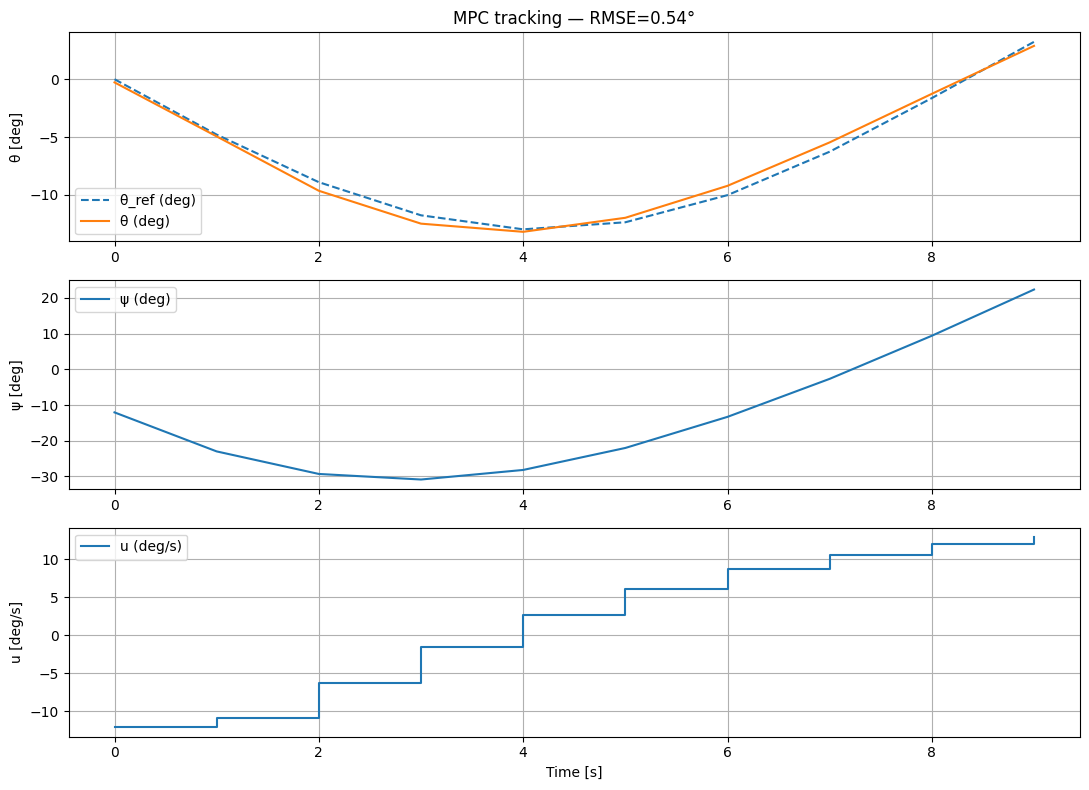

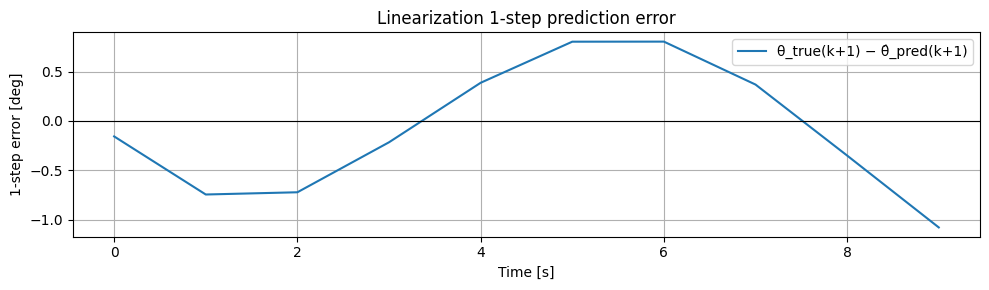

In [231]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [221]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=10,
    w_th=1000.0, w_u=1, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/1326349505.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L = float(-(E[0, :] @ M))                          # shape: (1 x n) -> scalar for n=1
/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/2710085576.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)


L=-2.660279,  lambda_cl=+0.007077

[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=34.00°  max|θ̂-R|=0.03°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -12.08 |       -12.08 |      -12.06 |       -4.78 |       -4.79 |         +0.00
 2 |       -11.00 |       -23.09 |      -23.06 |       -8.89 |       -8.90 |         +0.01
 3 |        -7.66 |       -30.75 |      -30.72 |      -11.75 |      -11.76 |         +0.01
 4 |        -3.24 |       -34.00 |      -33.97 |      -12.96 |      -12.97 |         +0.01
 5 |        +1.63 |       -32.36 |      -32.33 |      -12.35 |      -12.36 |         +0.01
 6 |        +6.28 |       -26.08 |      -26.05 |      -10.01 |      -10.02 |         +0.01
 7 |       +10.05 |       -16.03 |      -16.00 |       -6.26 |       -6.26 |         +0.01
 8 |       +12.40 |        -3.63 |       -3.60 |       -1.63 |       -1.63 |   

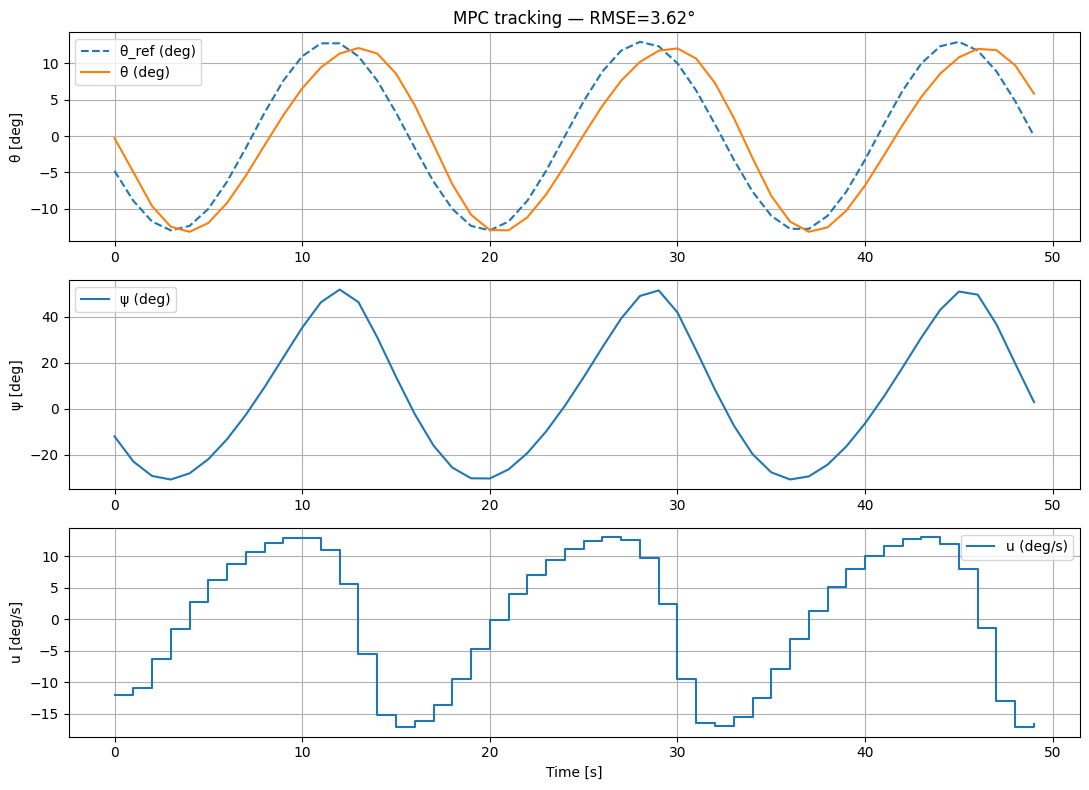

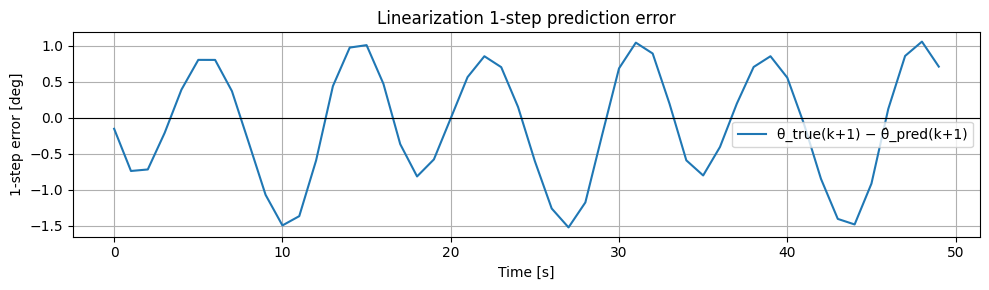

In [223]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [115]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=10,
    w_th=10.0, w_u=1, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/3609073591.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=37.42°  max|θ̂-R|=2.43°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -21.91 |       -21.91 |      -21.89 |      -11.25 |      -13.68 |         +2.43
 2 |        -9.00 |       -30.92 |      -30.89 |      -16.03 |      -16.85 |         +0.81
 3 |        -4.67 |       -35.59 |      -35.56 |      -18.51 |      -19.05 |         +0.54
 4 |        -1.83 |       -37.42 |      -37.39 |      -19.48 |      -19.98 |         +0.50
 5 |        +0.81 |       -36.61 |      -36.58 |      -19.05 |      -19.51 |         +0.46
 6 |        +3.23 |       -33.38 |      -33.35 |      -17.34 |      -17.71 |         +0.37
 7 |        +5.17 |       -28.21 |      -28.19 |      -14.60 |      -14.82 |         +0.22
 8 |        +6.35 |       -21.87 |      -21.84 |      -11.23 |      -11.25 |         +0.03
 9 |        +6.49 |   

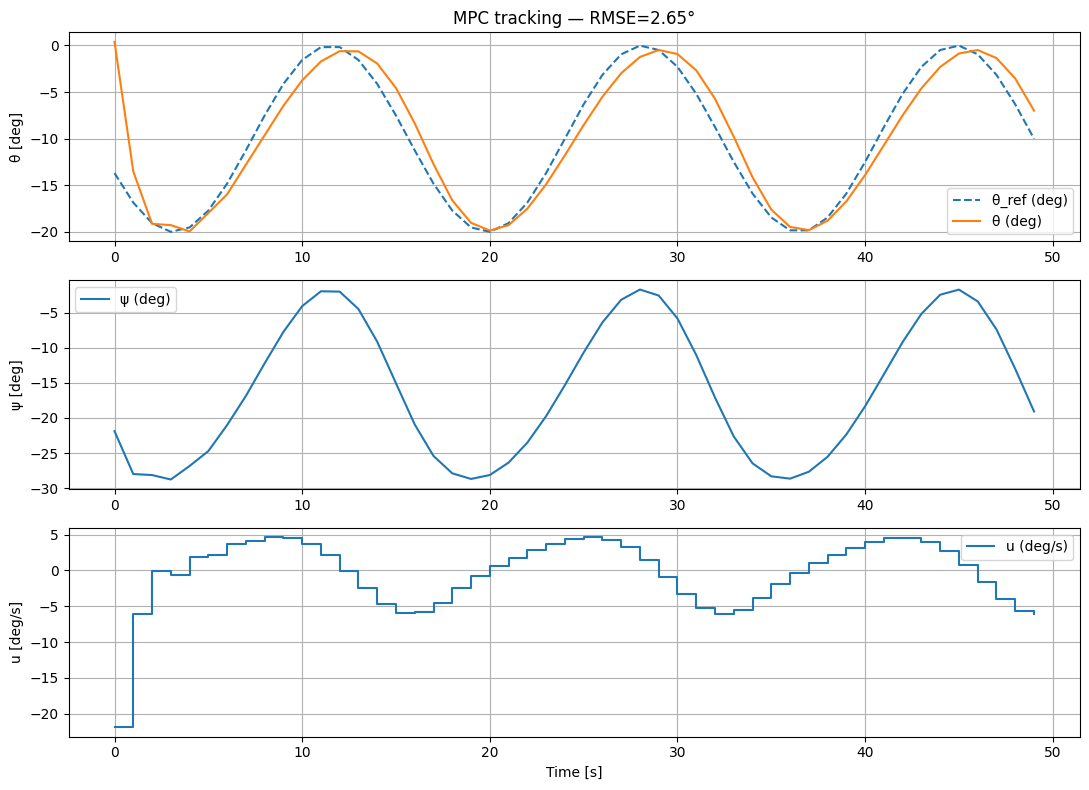

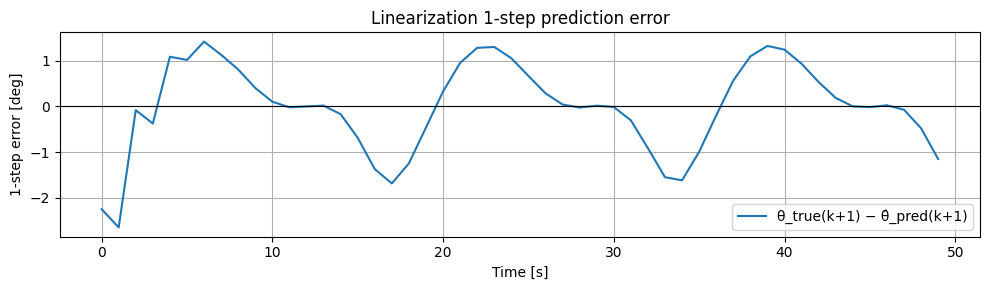

In [116]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [140]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=1,
    w_th=100.0, w_u=1, 
    psi0_rad=np.deg2rad(-17), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/3609073591.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)


KeyboardInterrupt: 

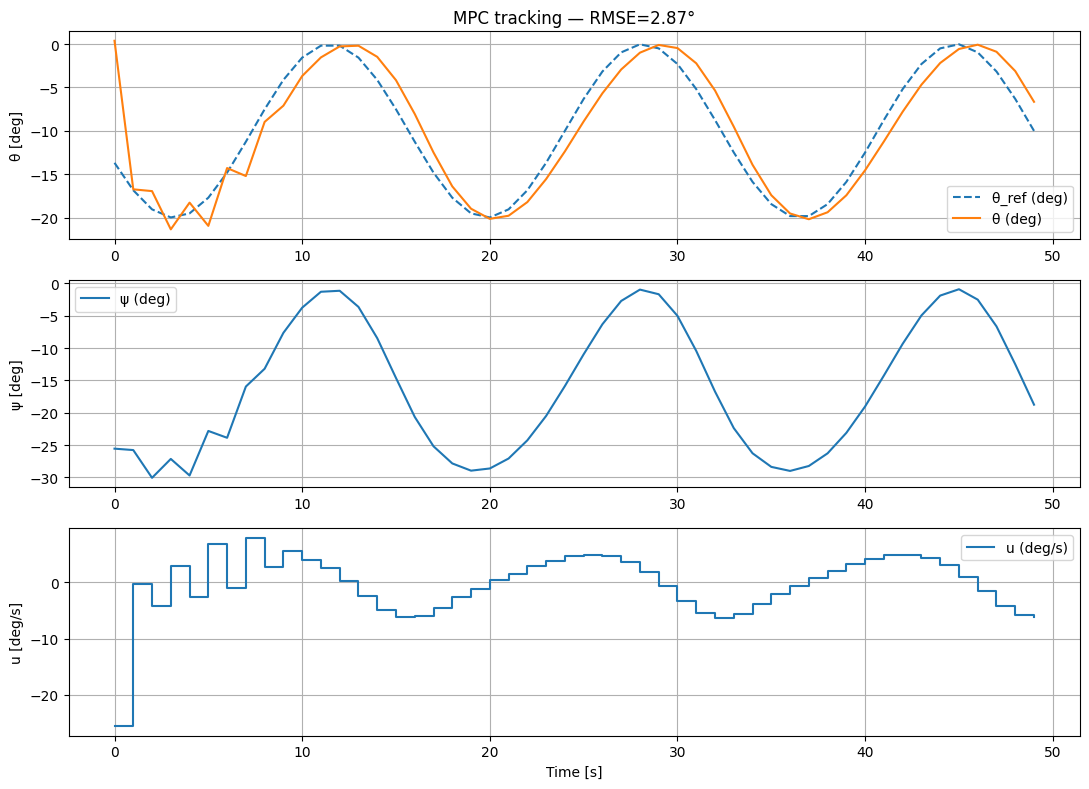

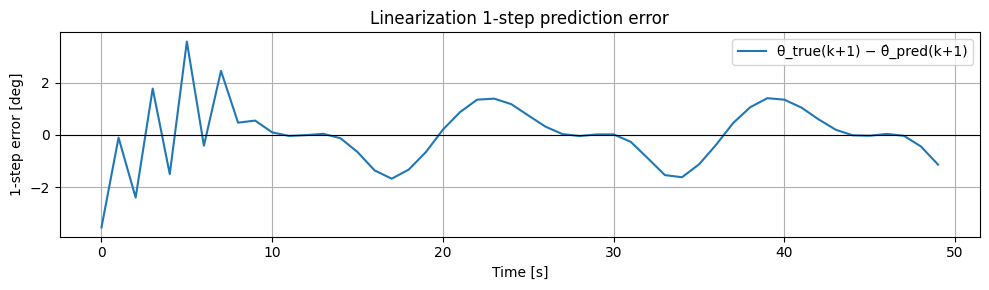

In [118]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [119]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=1,
    w_th=1000.0, w_u=1, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/3609073591.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=26.40°  max|θ̂-R|=0.05°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -26.40 |       -26.40 |      -26.37 |      -13.63 |      -13.68 |         +0.05
lam_min(C^T Q C)=2.82e+02  rho=3.55e-03

[Rollout] k=1  t=1.000s  ψ_k=-26.37°  max|Δψ|=1.43°  max|θ̂-R|=0.00°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        +1.43 |        +1.43 |      -24.94 |      -16.85 |      -16.85 |         -0.00
lam_min(C^T Q C)=2.17e+02  rho=4.61e-03

[Rollout] k=2  t=2.000s  ψ_k=-24.94°  max|Δψ|=6.06°  max|θ̂-R|=0.01°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
---------------------------------------------------------------------------

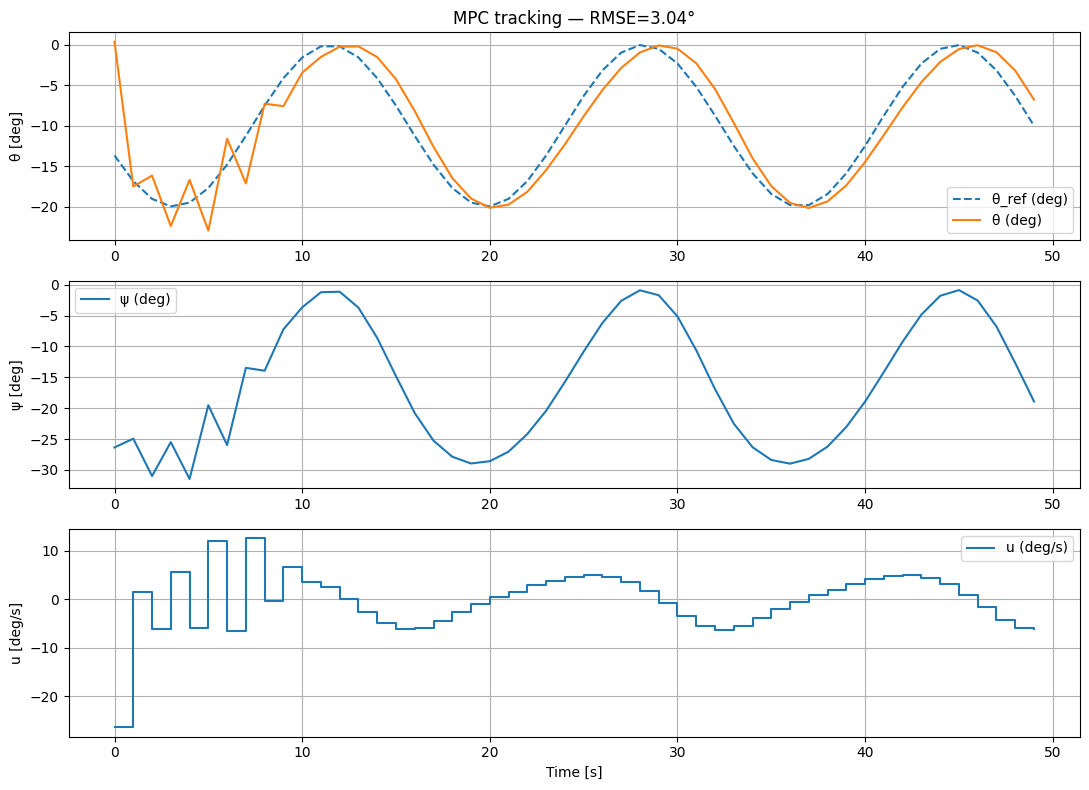

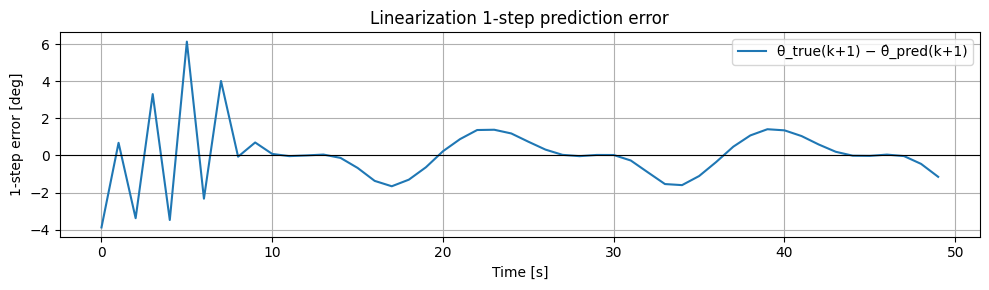

In [120]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [121]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=10,
    w_th=100.0, w_u=1, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/3609073591.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=38.26°  max|θ̂-R|=0.36°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -25.81 |       -25.81 |      -25.78 |      -13.32 |      -13.68 |         +0.36
 2 |        -6.56 |       -32.36 |      -32.34 |      -16.80 |      -16.85 |         +0.05
 3 |        -4.15 |       -36.51 |      -36.48 |      -19.00 |      -19.05 |         +0.05
 4 |        -1.75 |       -38.26 |      -38.23 |      -19.93 |      -19.98 |         +0.05
 5 |        +0.88 |       -37.38 |      -37.35 |      -19.46 |      -19.51 |         +0.05
 6 |        +3.38 |       -34.00 |      -33.97 |      -17.67 |      -17.71 |         +0.04
 7 |        +5.41 |       -28.59 |      -28.56 |      -14.79 |      -14.82 |         +0.02
 8 |        +6.68 |       -21.91 |      -21.88 |      -11.25 |      -11.25 |         +0.01
 9 |        +7.00 |   

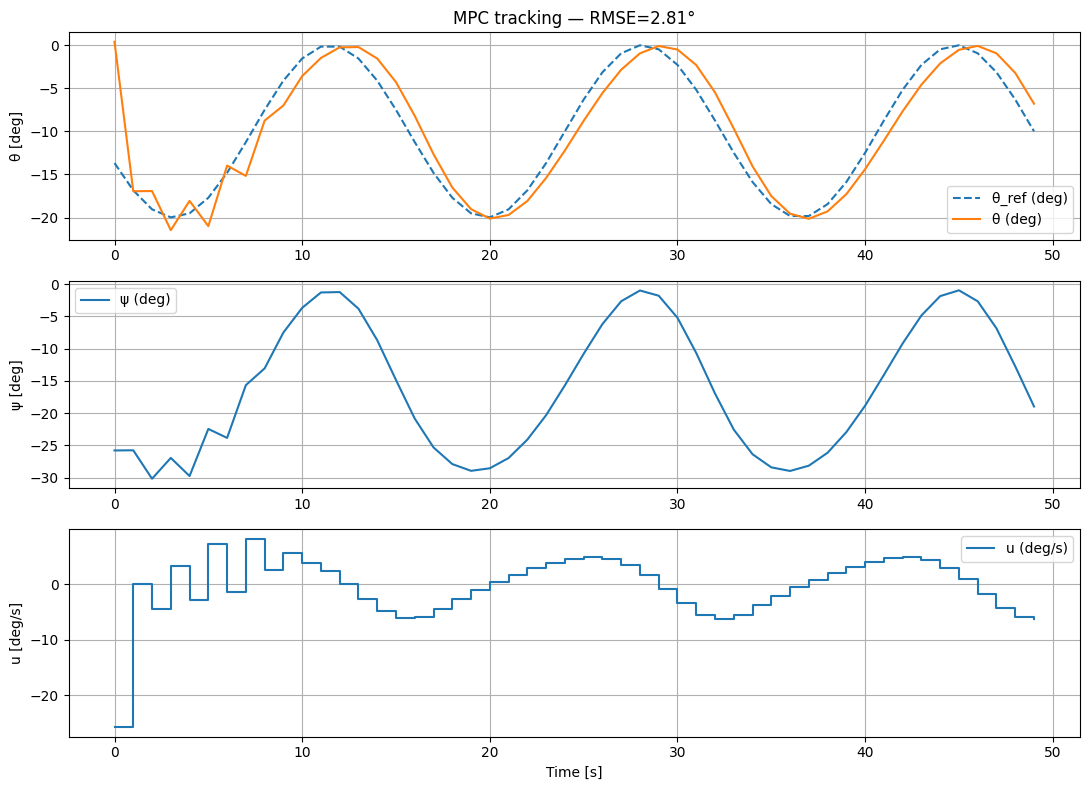

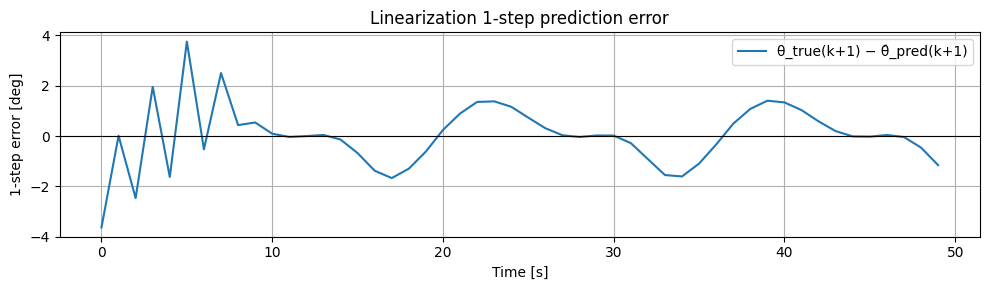

In [122]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [123]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=10,
    w_th=100.0, w_u=0, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/3609073591.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=38.35°  max|θ̂-R|=0.00°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -26.49 |       -26.49 |      -26.46 |      -13.68 |      -13.68 |         +0.00
 2 |        -5.96 |       -32.45 |      -32.42 |      -16.85 |      -16.85 |         -0.00
 3 |        -4.15 |       -36.60 |      -36.57 |      -19.05 |      -19.05 |         +0.00
 4 |        -1.75 |       -38.35 |      -38.33 |      -19.98 |      -19.98 |         +0.00
 5 |        +0.88 |       -37.47 |      -37.44 |      -19.51 |      -19.51 |         -0.00
 6 |        +3.40 |       -34.07 |      -34.04 |      -17.71 |      -17.71 |         +0.00
 7 |        +5.44 |       -28.63 |      -28.60 |      -14.82 |      -14.82 |         +0.00
 8 |        +6.71 |       -21.92 |      -21.89 |      -11.25 |      -11.25 |         +0.00
 9 |        +7.04 |   

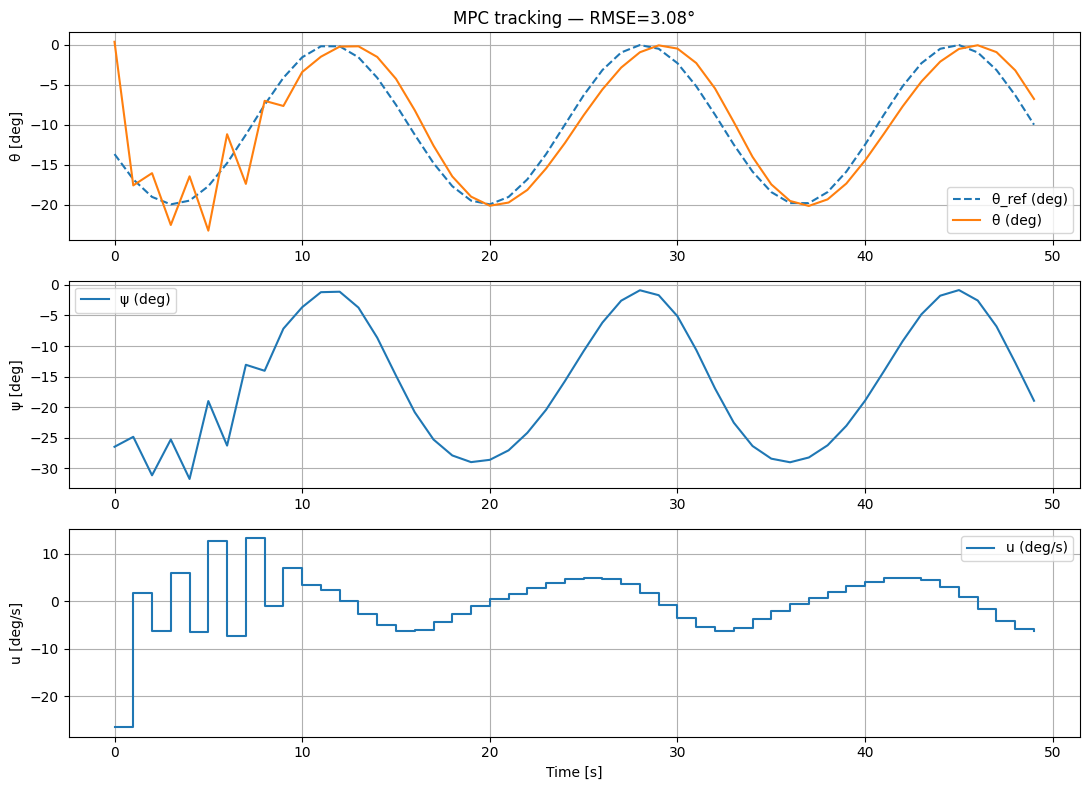

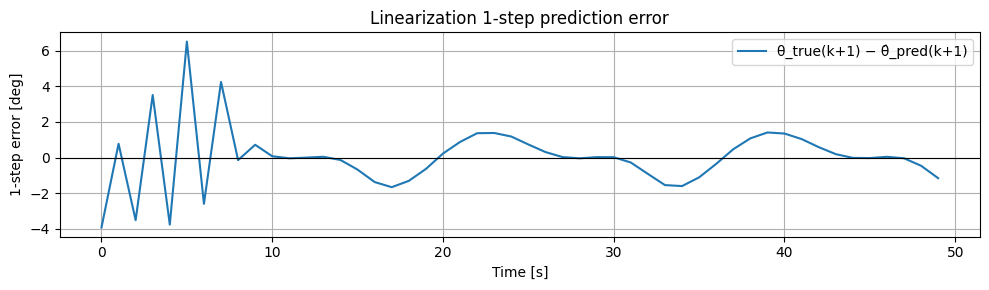

In [124]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [127]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=10,
    w_th=10.0, w_u=0.5, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/3609073591.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=37.89°  max|θ̂-R|=1.47°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -23.72 |       -23.72 |      -23.69 |      -12.21 |      -13.68 |         +1.47
 2 |        -8.07 |       -31.79 |      -31.76 |      -16.49 |      -16.85 |         +0.35
 3 |        -4.35 |       -36.14 |      -36.11 |      -18.80 |      -19.05 |         +0.24
 4 |        -1.75 |       -37.89 |      -37.86 |      -19.73 |      -19.98 |         +0.25
 5 |        +0.86 |       -37.03 |      -37.00 |      -19.28 |      -19.51 |         +0.23
 6 |        +3.32 |       -33.72 |      -33.69 |      -17.52 |      -17.71 |         +0.19
 7 |        +5.30 |       -28.41 |      -28.38 |      -14.70 |      -14.82 |         +0.12
 8 |        +6.54 |       -21.88 |      -21.85 |      -11.23 |      -11.25 |         +0.02
 9 |        +6.79 |   

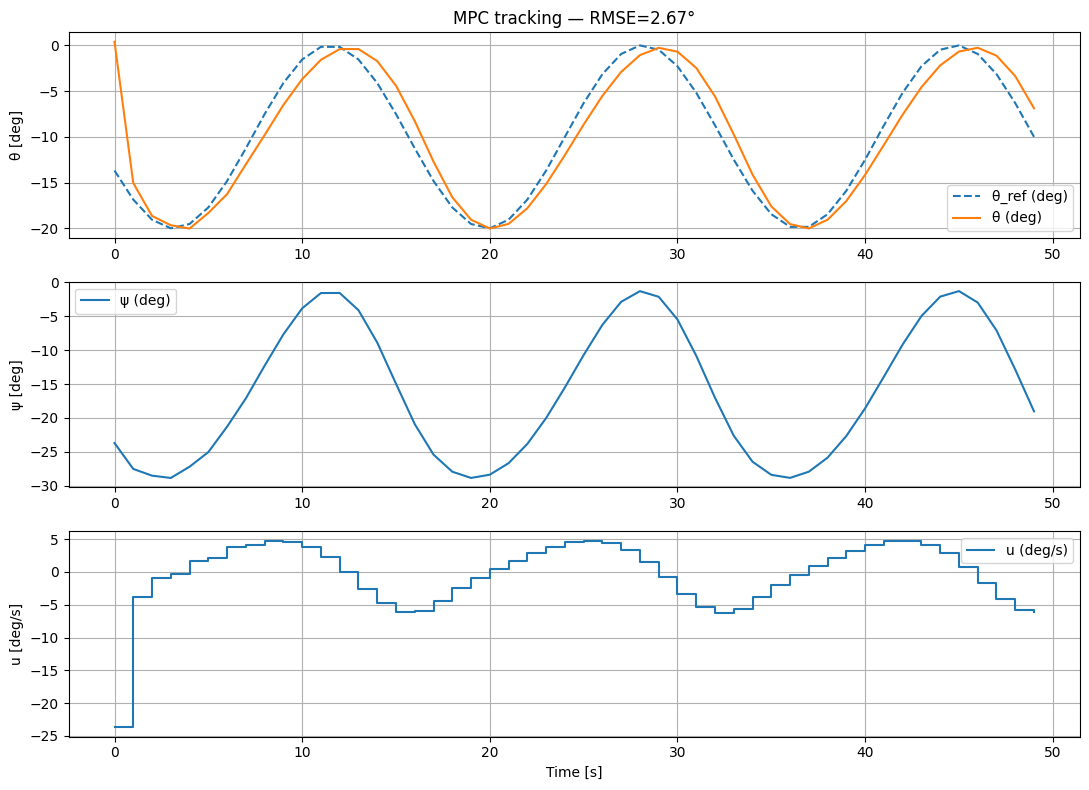

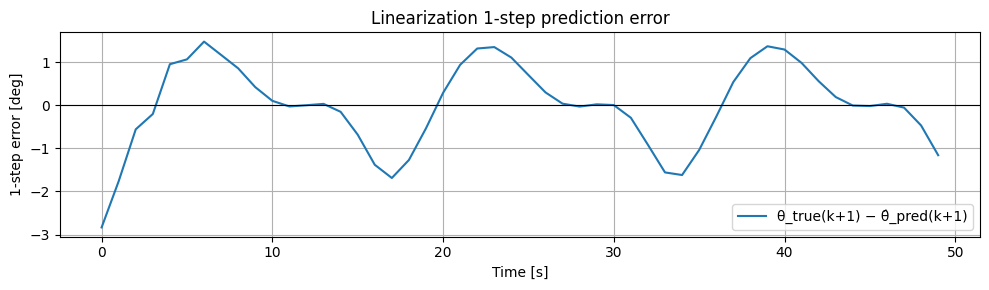

In [128]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [129]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=20,
    w_th=10.0, w_u=0.5, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/3609073591.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=37.89°  max|θ̂-R|=1.47°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -23.72 |       -23.72 |      -23.69 |      -12.21 |      -13.68 |         +1.47
 2 |        -8.07 |       -31.79 |      -31.76 |      -16.49 |      -16.85 |         +0.35
 3 |        -4.35 |       -36.14 |      -36.11 |      -18.80 |      -19.05 |         +0.24
 4 |        -1.75 |       -37.89 |      -37.86 |      -19.73 |      -19.98 |         +0.25
 5 |        +0.86 |       -37.03 |      -37.00 |      -19.28 |      -19.51 |         +0.23
 6 |        +3.32 |       -33.72 |      -33.69 |      -17.52 |      -17.71 |         +0.19
 7 |        +5.31 |       -28.41 |      -28.38 |      -14.70 |      -14.82 |         +0.12
 8 |        +6.55 |       -21.86 |      -21.83 |      -11.22 |      -11.25 |         +0.03
 9 |        +6.87 |   

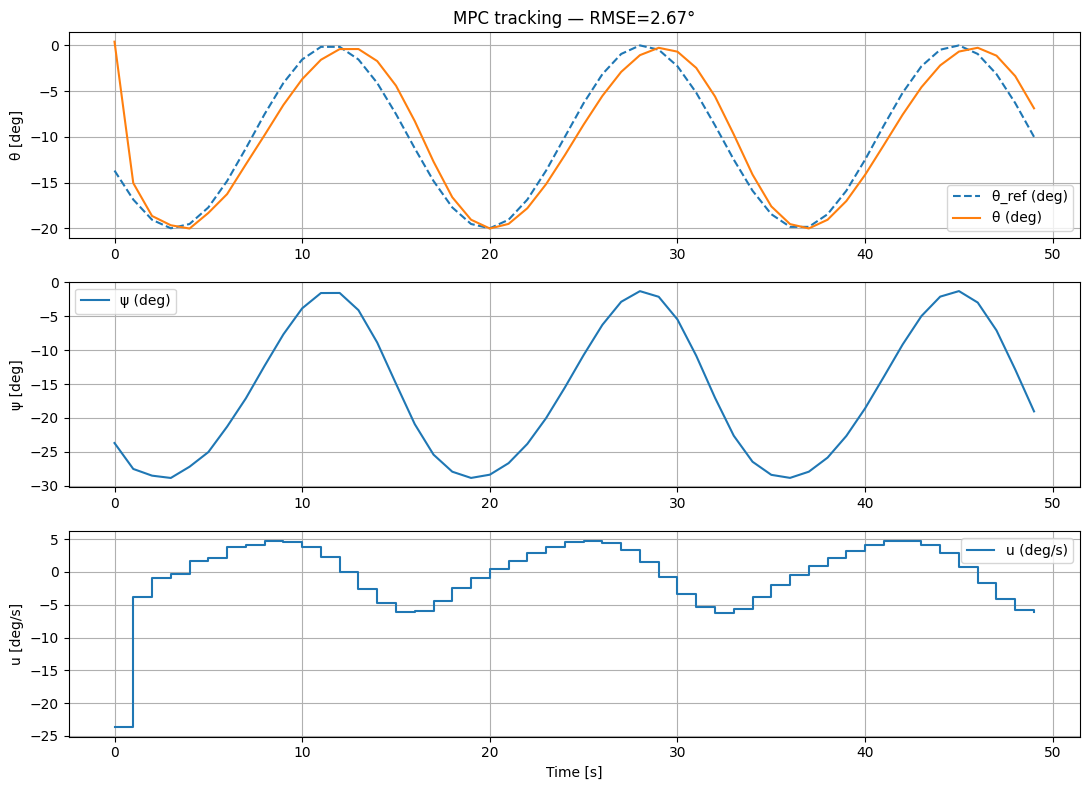

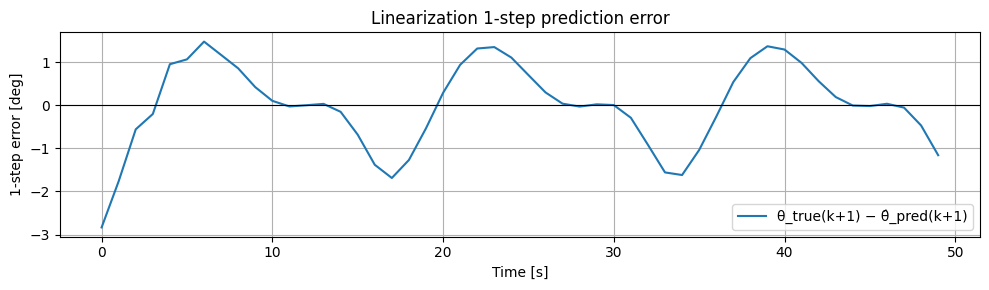

In [130]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


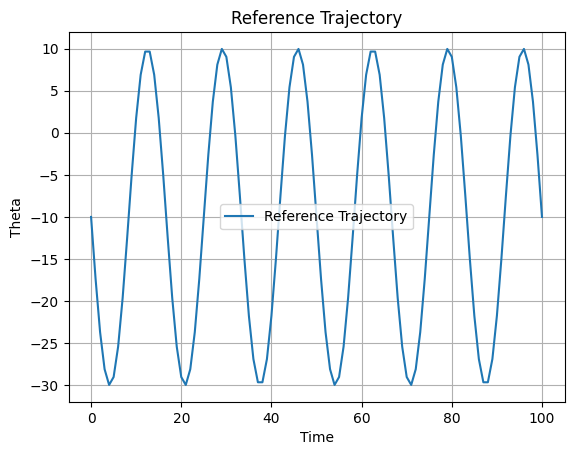

In [137]:
p_vec = np.array([0.0, 0.18, 0.0])
A_deg = np.deg2rad(20)      
f_hz = 0.06  
offset_deg = np.deg2rad(-10.0)  
phase_deg = 0.0  
T = 50.0          
dt = 1     
Np = 3   
ref = make_ref_sine(A_deg, f_hz, offset_deg, phase_deg)
t = np.arange(0.0, time+dt, dt)
theta = np.array([ref(test)[0] for test in t])
theta_dot = np.array([ref(test)[1] for test in t])


plt.figure()
plt.plot(t, np.rad2deg(theta), label="Reference Trajectory")
# plt.plot(t, np.rad2deg(theta_dot), label="Derivative of Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Reference Trajectory")
plt.legend()
plt.grid()
plt.show()

In [143]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=1,
    w_th=10.0, w_u=0, 
    psi0_rad=np.deg2rad(-17), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/3609073591.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=-17.00°  max|Δψ|=15.15°  max|θ̂-R|=0.00°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -15.15 |       -15.15 |      -32.15 |      -17.36 |      -17.36 |         +0.00
lam_min(C^T Q C)=2.55e+00  rho=0.00e+00

[Rollout] k=1  t=1.000s  ψ_k=-32.15°  max|Δψ|=0.24°  max|θ̂-R|=0.00°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        +0.24 |        +0.24 |      -31.91 |      -23.69 |      -23.69 |         +0.00
lam_min(C^T Q C)=1.89e+00  rho=0.00e+00

[Rollout] k=2  t=2.000s  ψ_k=-31.91°  max|Δψ|=10.54°  max|θ̂-R|=0.00°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
-------------------------------------------------------------------------

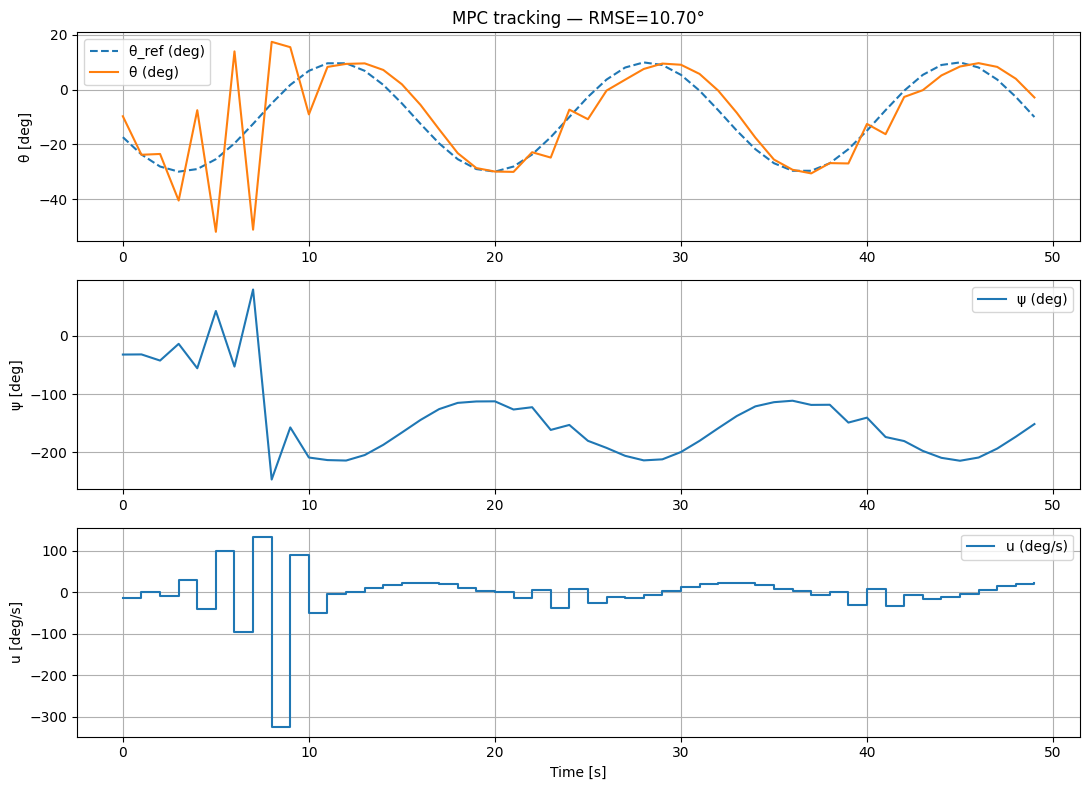

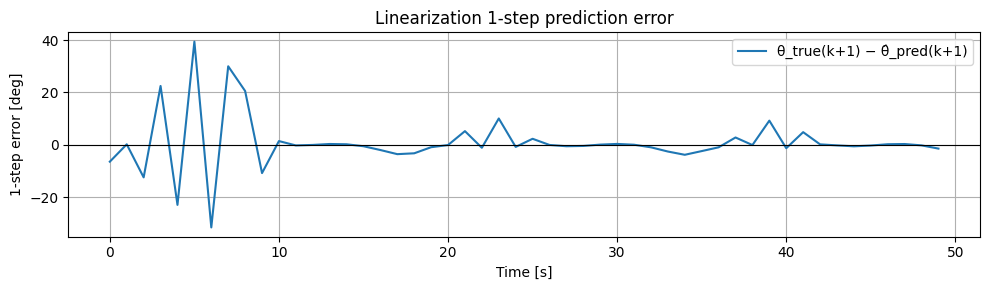

In [144]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [145]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=1,
    w_th=10.0, w_u=1, 
    psi0_rad=np.deg2rad(-17), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/3609073591.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=-17.00°  max|Δψ|=10.88°  max|θ̂-R|=2.16°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -10.88 |       -10.88 |      -27.88 |      -15.21 |      -17.36 |         +2.16
lam_min(C^T Q C)=2.55e+00  rho=3.93e-01

[Rollout] k=1  t=1.000s  ψ_k=-27.88°  max|Δψ|=6.92°  max|θ̂-R|=1.51°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        -6.92 |        -6.92 |      -34.80 |      -22.18 |      -23.69 |         +1.51
lam_min(C^T Q C)=2.10e+00  rho=4.76e-01

[Rollout] k=2  t=2.000s  ψ_k=-34.80°  max|Δψ|=1.22°  max|θ̂-R|=0.29°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------

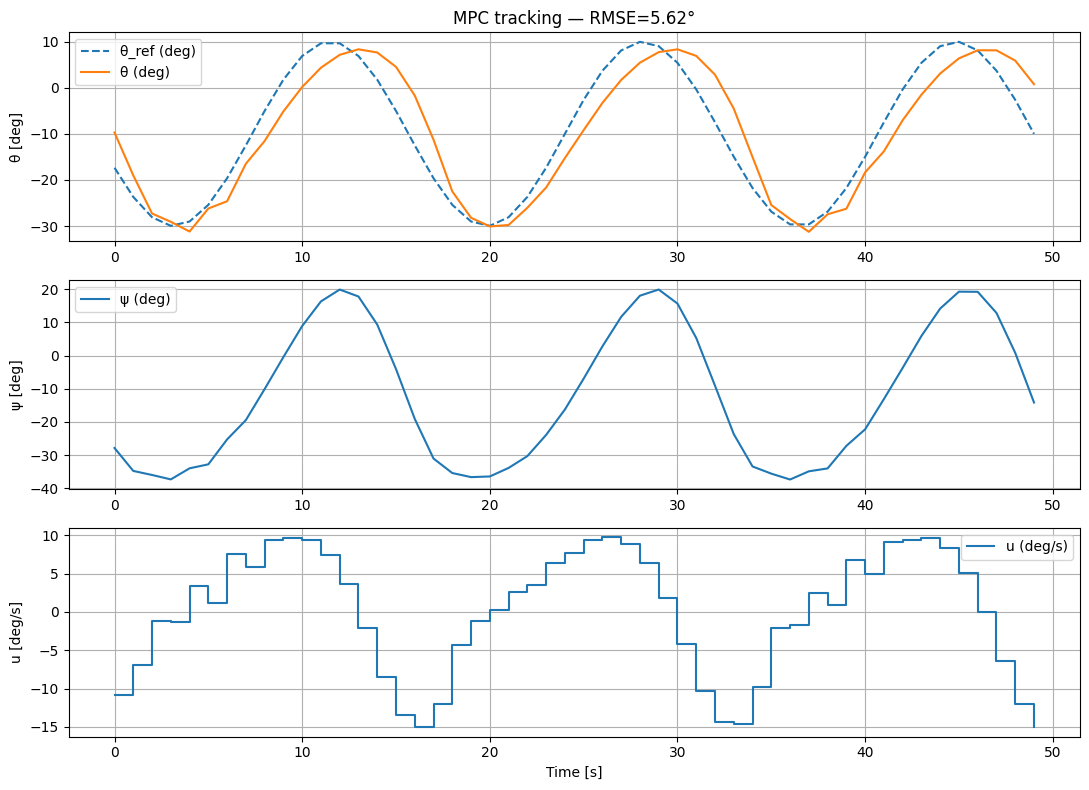

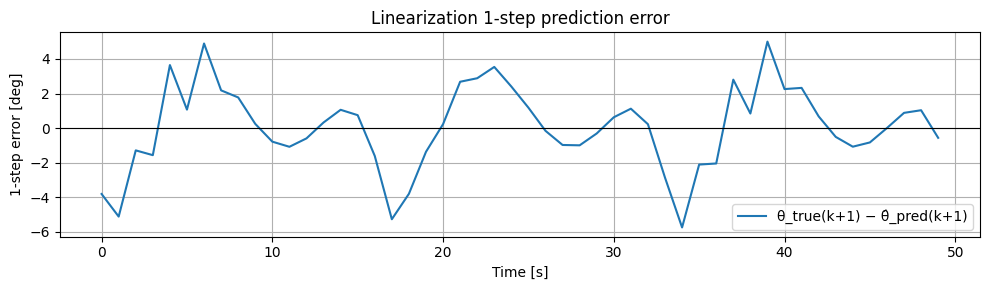

In [146]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [147]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=10,
    w_th=10.0, w_u=1, 
    psi0_rad=np.deg2rad(-17), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/3609073591.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=-17.00°  max|Δψ|=38.04°  max|θ̂-R|=2.08°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -14.26 |       -14.26 |      -31.26 |      -16.91 |      -17.36 |         +0.45
 2 |       -11.98 |       -26.24 |      -43.24 |      -22.96 |      -23.69 |         +0.73
 3 |        -8.30 |       -34.54 |      -51.54 |      -27.15 |      -28.10 |         +0.95
 4 |        -3.51 |       -38.04 |      -55.04 |      -28.92 |      -29.96 |         +1.04
 5 |        +1.76 |       -36.28 |      -53.28 |      -28.03 |      -29.02 |         +0.99
 6 |        +6.77 |       -29.51 |      -46.51 |      -24.61 |      -25.41 |         +0.80
 7 |       +10.82 |       -18.69 |      -35.69 |      -19.15 |      -19.64 |         +0.49
 8 |       +13.27 |        -5.42 |      -22.42 |      -12.45 |      -12.51 |         +0.05
 9 |       +13.53 |  

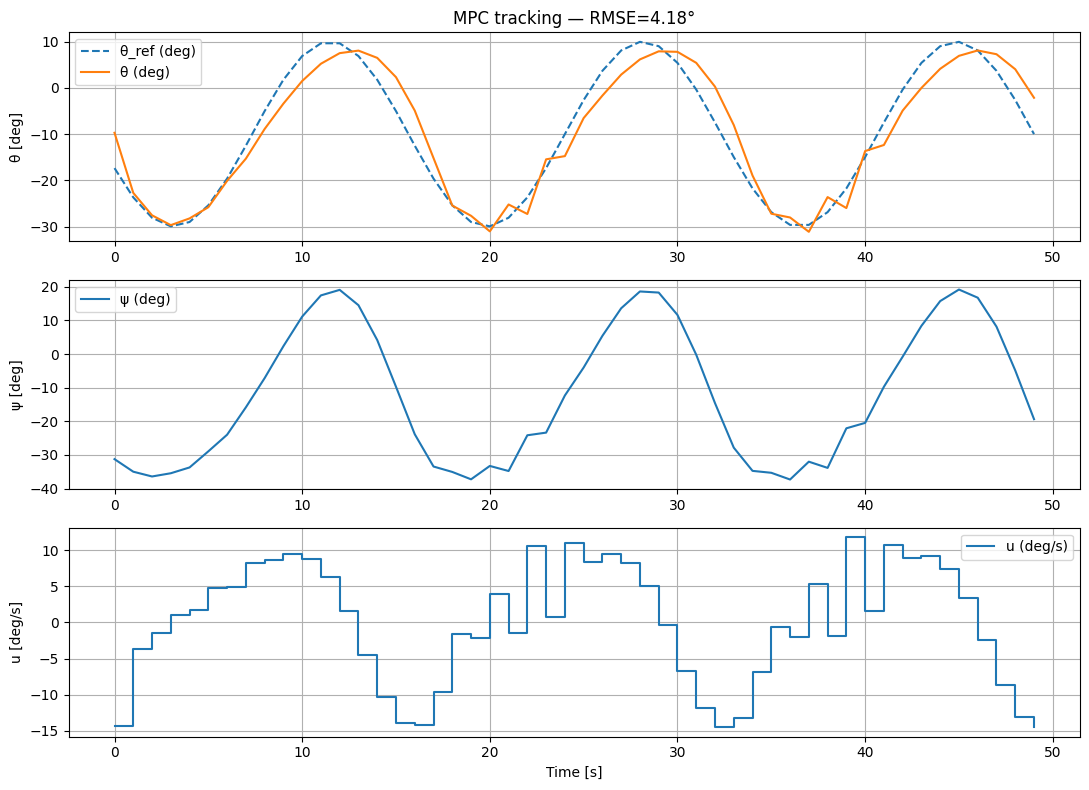

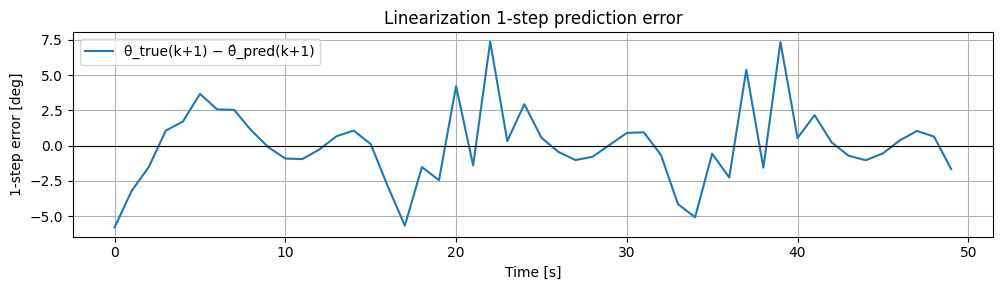

In [148]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [154]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=10,
    w_th=10.0, w_u=1, 
    psi0_rad=np.deg2rad(-17), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/4233052955.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=-17.00°  max|Δψ|=38.04°  max|θ̂-R|=1.04°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -14.26 |       -14.26 |      -31.26 |      -16.91 |      -17.36 |         +0.45
 2 |       -11.98 |       -26.24 |      -43.24 |      -22.96 |      -23.69 |         +0.73
 3 |        -8.30 |       -34.54 |      -51.54 |      -27.15 |      -28.10 |         +0.95
 4 |        -3.51 |       -38.04 |      -55.04 |      -28.92 |      -29.96 |         +1.04
 5 |        +1.76 |       -36.28 |      -53.28 |      -28.03 |      -29.02 |         +0.99
 6 |        +6.78 |       -29.50 |      -46.50 |      -24.60 |      -25.41 |         +0.81
 7 |       +10.85 |       -18.65 |      -35.65 |      -19.13 |      -19.64 |         +0.50
 8 |       +13.39 |        -5.26 |      -22.26 |      -12.37 |      -12.51 |         +0.14
 9 |       +14.08 |  

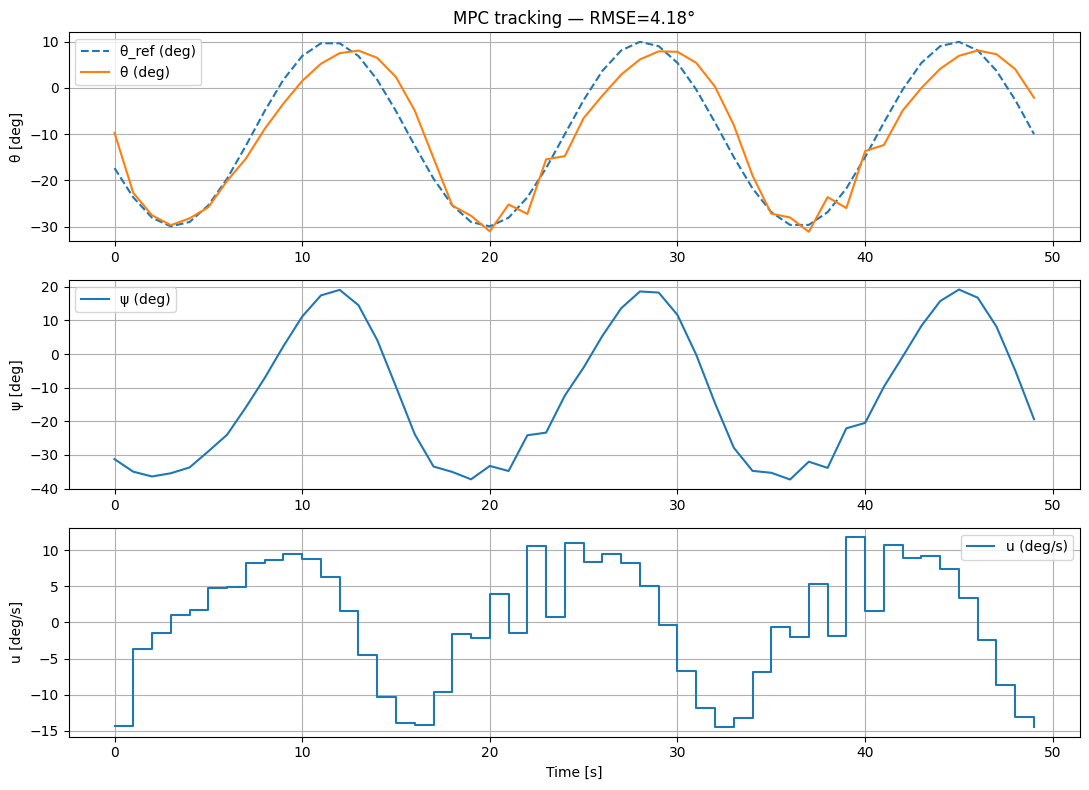

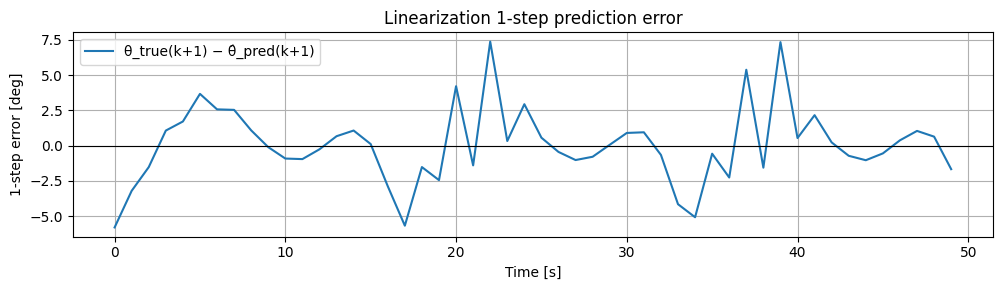

In [151]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [178]:
#terminal horizon is not the same 1e6
out = simple_mpc(
    ref, T, dt, p_vec,
    Np=4,
    w_th=10.0, w_u=4, 
    psi0_rad=np.deg2rad(-17), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/2177779448.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=-17.00°  max|Δψ|=40.11°  max|θ̂-R|=1.80°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -12.80 |       -12.80 |      -29.80 |      -16.18 |      -17.36 |         +1.18
 2 |       -11.31 |       -24.12 |      -41.12 |      -21.89 |      -23.69 |         +1.80
 3 |        -9.04 |       -33.15 |      -50.15 |      -26.45 |      -28.10 |         +1.65
 4 |        -6.96 |       -40.11 |      -57.11 |      -29.96 |      -29.96 |         +0.00
lam_min(C^T Q C)=7.46e-01  rho=5.36e+00

[Rollout] k=1  t=1.000s  ψ_k=-29.80°  max|Δψ|=17.77°  max|θ̂-R|=1.81°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        -5.91 |        -5.91 |      -35.71 |      -23.71 |      -23.69 |         -0.02
 2 

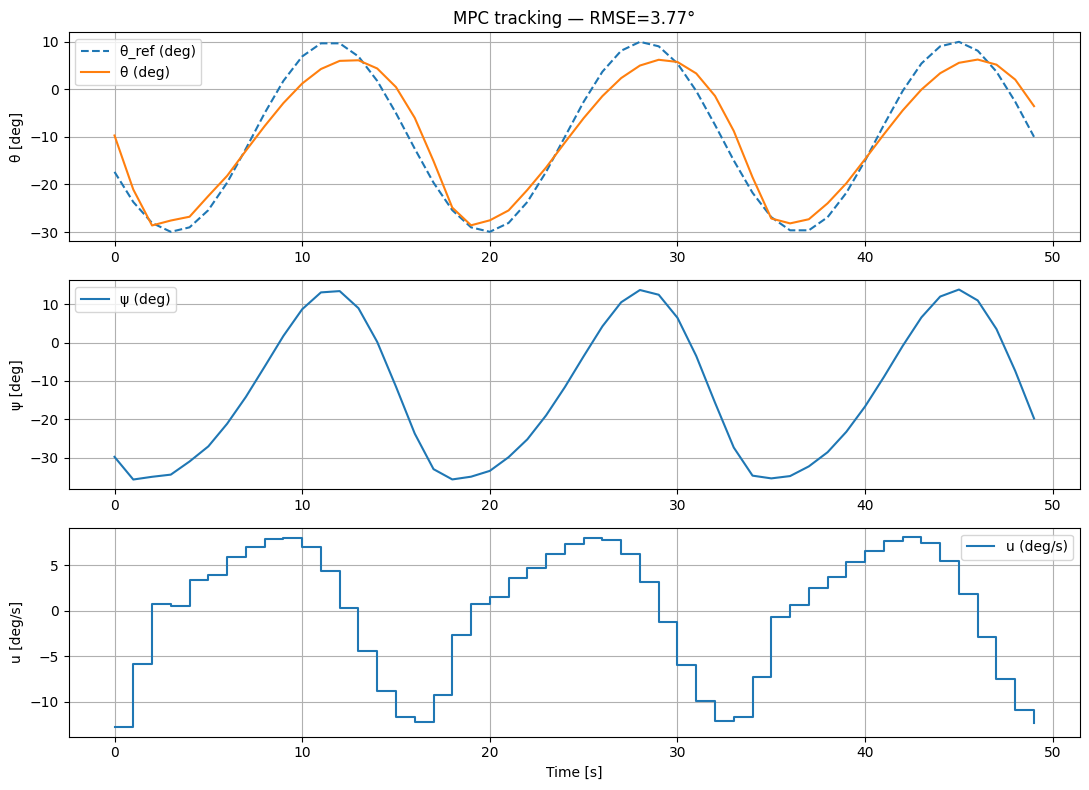

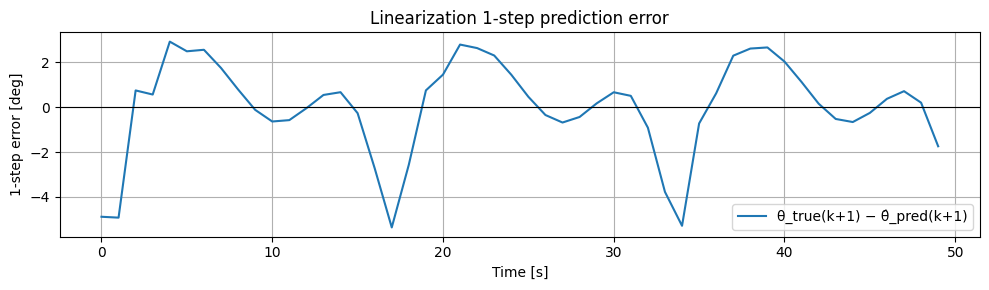

In [179]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [181]:
#terminal horizon is not the same 1e6
out = simple_mpc(
    ref, T, dt, p_vec,
    Np=4,
    w_th=1000.0, w_u=7, 
    psi0_rad=np.deg2rad(-17), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/2177779448.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=-17.00°  max|Δψ|=40.11°  max|θ̂-R|=0.07°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -15.08 |       -15.08 |      -32.08 |      -17.33 |      -17.36 |         +0.04
 2 |       -12.51 |       -27.58 |      -44.58 |      -23.64 |      -23.69 |         +0.05
 3 |        -8.70 |       -36.28 |      -53.28 |      -28.03 |      -28.10 |         +0.07
 4 |        -3.83 |       -40.11 |      -57.11 |      -29.96 |      -29.96 |         +0.00
lam_min(C^T Q C)=7.46e+01  rho=9.38e-02

[Rollout] k=1  t=1.000s  ψ_k=-32.08°  max|Δψ|=14.13°  max|θ̂-R|=0.15°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        -0.30 |        -0.30 |      -32.38 |      -23.84 |      -23.69 |         -0.15
 2 

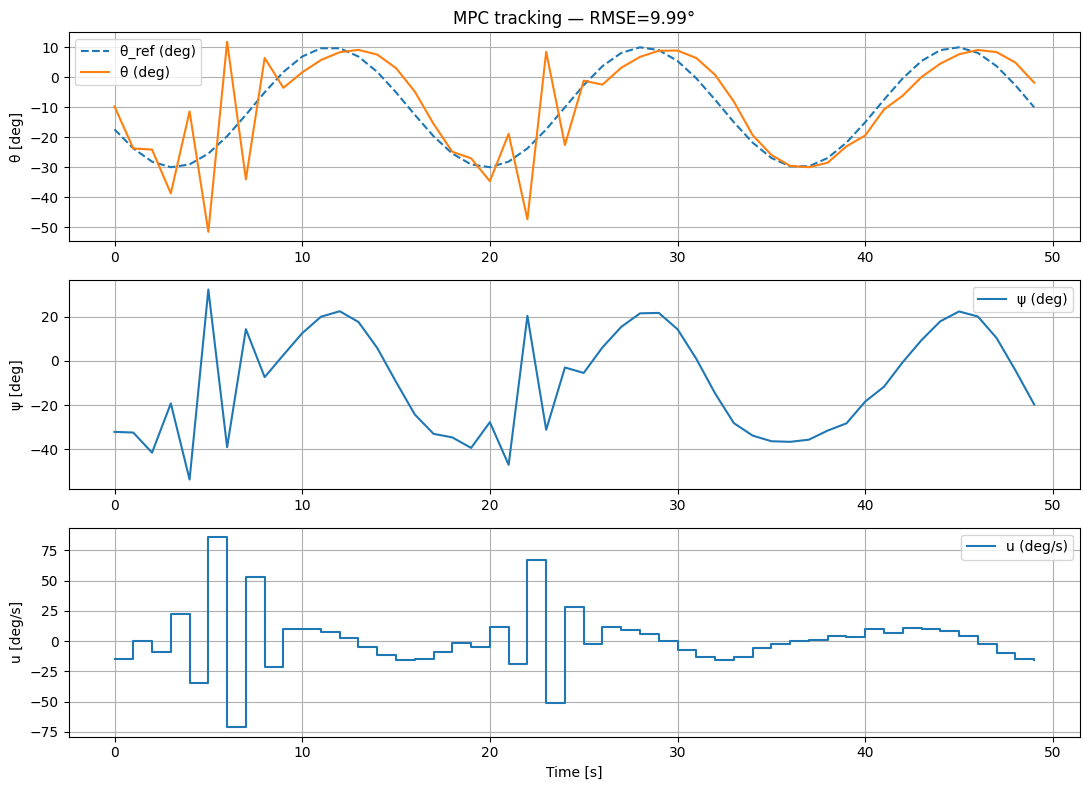

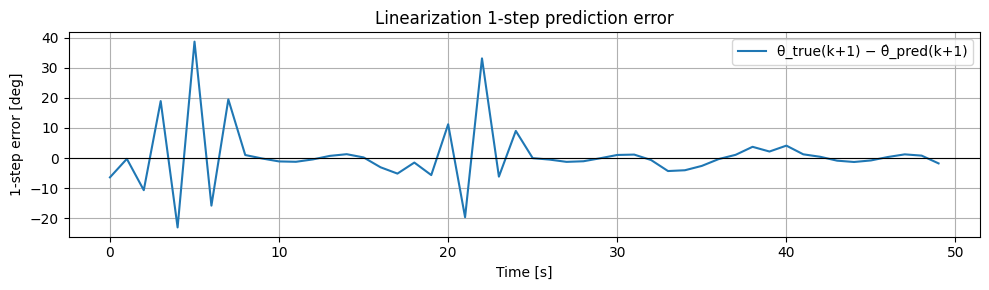

In [182]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [206]:
#terminal horizon is not the same
out = simple_mpc(
    ref, T, dt, p_vec,
    Np=10,
    w_th=100.0, w_u=25, 
    psi0_rad=np.deg2rad(-17), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/1326349505.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L = float(-(E[0, :] @ M))                          # shape: (1 x n) -> scalar for n=1
/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/2710085576.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)


L=-1.230913,  lambda_cl=+0.378786

[Rollout] k=0  t=0.000s  ψ_k=-17.00°  max|Δψ|=35.33°  max|θ̂-R|=4.17°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -13.17 |       -13.17 |      -30.17 |      -16.36 |      -17.36 |         +1.00
 2 |       -11.15 |       -24.32 |      -41.32 |      -21.99 |      -23.69 |         +1.70
 3 |        -7.73 |       -32.05 |      -49.05 |      -25.89 |      -28.10 |         +2.20
 4 |        -3.27 |       -35.33 |      -52.33 |      -27.54 |      -29.96 |         +2.42
 5 |        +1.60 |       -33.72 |      -50.72 |      -26.74 |      -29.02 |         +2.29
 6 |        +6.22 |       -27.51 |      -44.51 |      -23.60 |      -25.41 |         +1.81
 7 |        +9.87 |       -17.64 |      -34.64 |      -18.62 |      -19.64 |         +1.02
 8 |       +11.93 |        -5.71 |      -22.71 |      -12.60 |      -12.51 |  

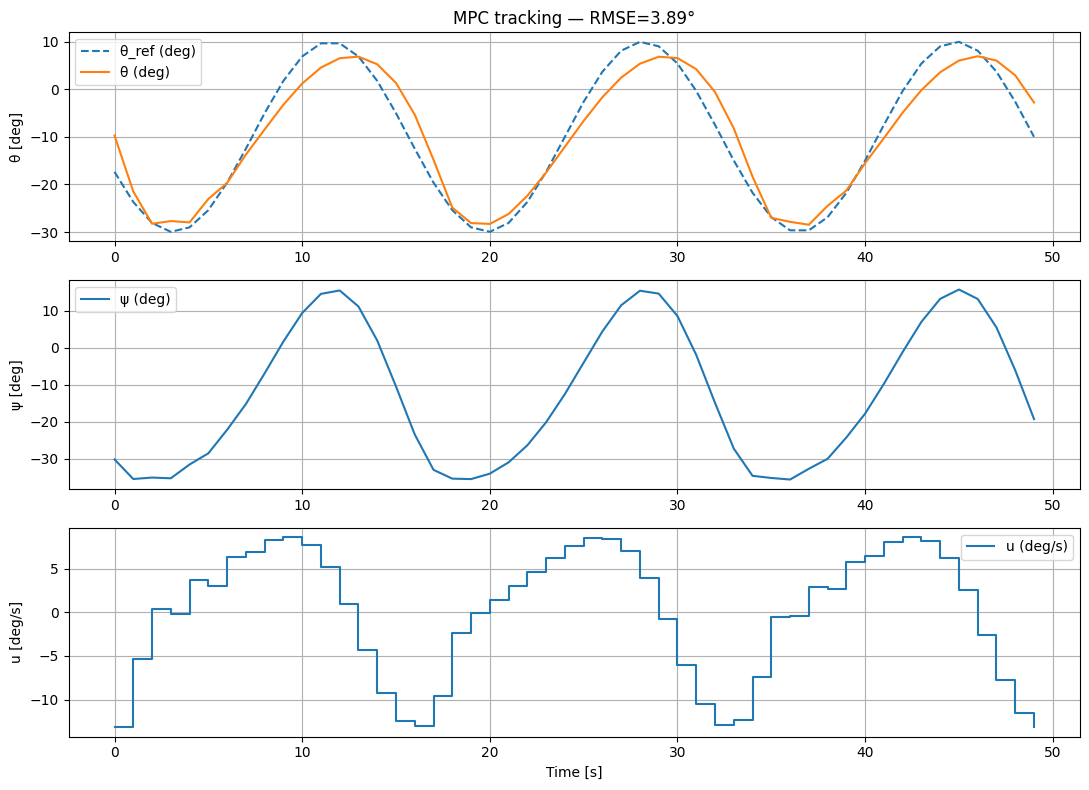

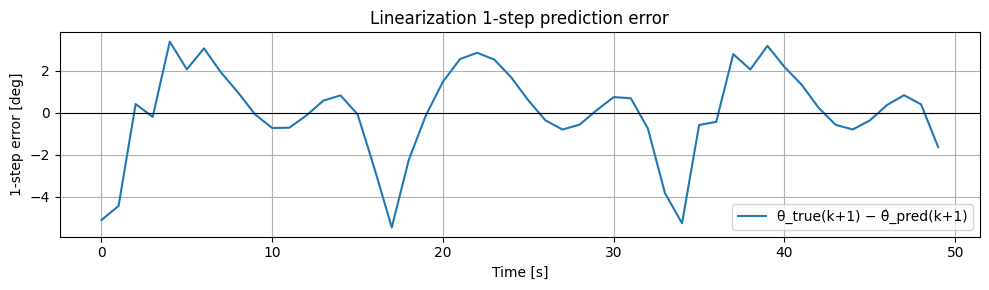

In [207]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [ ]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=10,
    w_th=100.0, w_u=10, 
    psi0_rad=np.deg2rad(-17), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/1326349505.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L = float(-(E[0, :] @ M))                          # shape: (1 x n) -> scalar for n=1
/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_87874/2710085576.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)


L=-1.522272,  lambda_cl=+0.231744

[Rollout] k=0  t=0.000s  ψ_k=-17.00°  max|Δψ|=38.58°  max|θ̂-R|=0.89°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -14.26 |       -14.26 |      -31.26 |      -16.92 |      -17.36 |         +0.45
 2 |       -12.01 |       -26.27 |      -43.27 |      -22.97 |      -23.69 |         +0.72
 3 |        -8.39 |       -34.66 |      -51.66 |      -27.21 |      -28.10 |         +0.89
 4 |        -3.91 |       -38.58 |      -55.58 |      -29.18 |      -29.96 |         +0.78
lam_min(C^T Q C)=7.21e+00  rho=1.39e+00
L=-1.652222,  lambda_cl=+0.273034

[Rollout] k=1  t=1.000s  ψ_k=-31.26°  max|Δψ|=14.43°  max|θ̂-R|=0.88°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        -3.78 |       

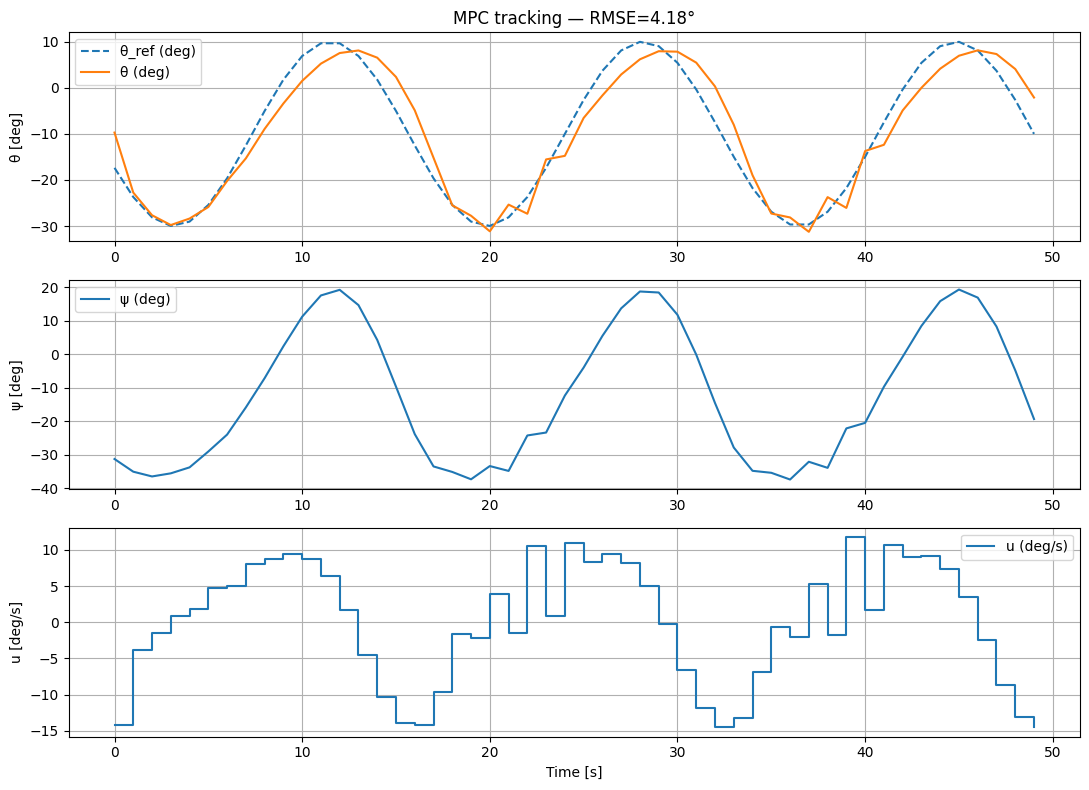

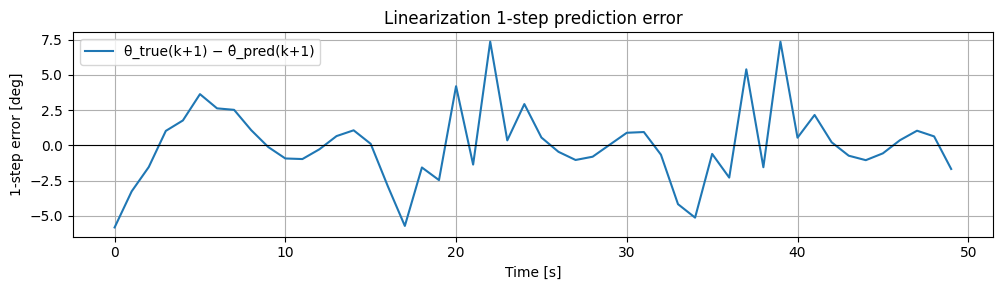

In [205]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [ ]:
def validate_linearization_at(psi_k_deg, *, p_vec, dmax_deg=20.0, n_pts=41, s_steps=200):

    psi_k = np.deg2rad(psi_k_deg)

    def measure_theta(psi_rad):
        th, _, _, _ = simulate_beam(
            p_vec, np.rad2deg(psi_rad),
            L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M,
            m_line_of_s=m_line_of_s, s_steps=s_steps
        )
        return float(th)

    def jacobian_at(psi_rad):
        _, Jpsi, _ = jacobian_tip_from_sim2(
            p_vec, np.rad2deg(psi_rad),
            L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M,
            m_line_of_s=m_line_of_s, s_steps=s_steps
        )
        return float(Jpsi)

    theta0 = measure_theta(psi_k)
    J0     = jacobian_at(psi_k)

    dpsi_list = np.linspace(-np.deg2rad(dmax_deg), np.deg2rad(dmax_deg), n_pts)
    theta_true = np.array([measure_theta(psi_k + d) for d in dpsi_list])
    theta_lin  = theta0 + J0 * dpsi_list

    err = theta_true - theta_lin
    rmse = float(np.sqrt(np.mean(err**2)))
    max_abs = float(np.max(np.abs(err)))

    print(f"ψk={psi_k_deg:.2f} deg:  J0={J0:.4g} rad/rad,  RMSE={np.degrees(rmse):.4f} deg,  max|err|={np.degrees(max_abs):.4f} deg")

    plt.figure()
    plt.plot(np.degrees(psi_k + dpsi_list), np.degrees(theta_true), label="θ true")
    plt.plot(np.degrees(psi_k + dpsi_list), np.degrees(theta_lin),  "--", label="θ linear")
    plt.xlabel("ψ [deg]"); plt.ylabel("θ [deg]"); plt.title(f"Linearization @ p={np.array(p_vec)}")
    plt.grid(True); plt.legend()

    plt.figure()
    plt.plot(np.degrees(dpsi_list), np.degrees(err))
    plt.xlabel("Δψ [deg]"); plt.ylabel("θ_true - θ_lin [deg]")
    plt.title("Linearization error vs Δψ")
    plt.grid(True)

    return dict(
        p_vec=np.array(p_vec, float),
        psi_k_deg=float(psi_k_deg),
        J0=float(J0),
        theta0=float(theta0),
        rmse=rmse,
        max_abs=max_abs,
    )


ψk=30.55 deg:  J0=0.2079 rad/rad,  RMSE=0.0374 deg,  max|err|=0.1010 deg


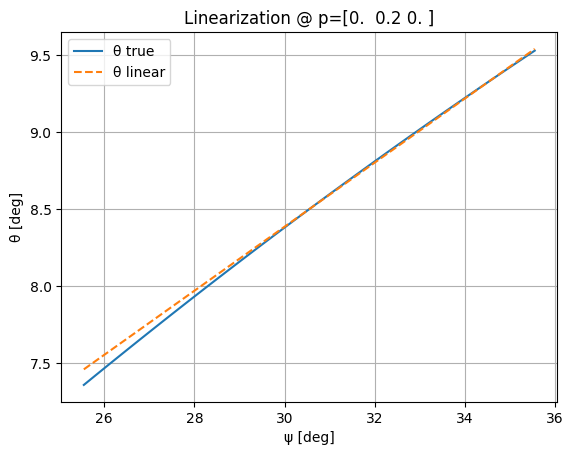

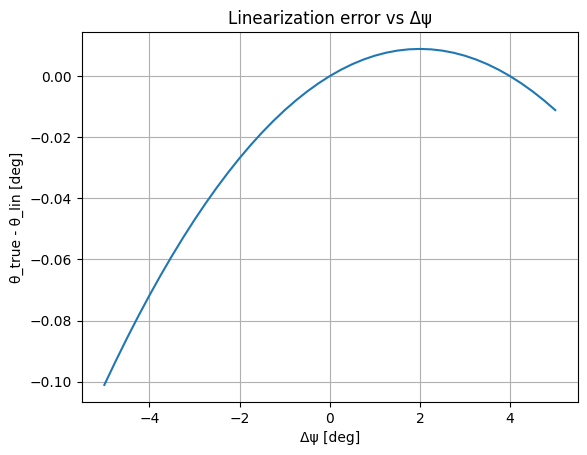

In [ ]:
k = -1
# reconstruct ψ before applying u at step k:
psi_before_deg = out["psi_deg"][k] - out["u_deg_s"][k]*dt
res = validate_linearization_at(psi_before_deg, p_vec=p_vec, dmax_deg=5.0, n_pts=41)


ψk=31.83 deg:  J0=0.2748 rad/rad,  RMSE=1.1330 deg,  max|err|=2.9391 deg


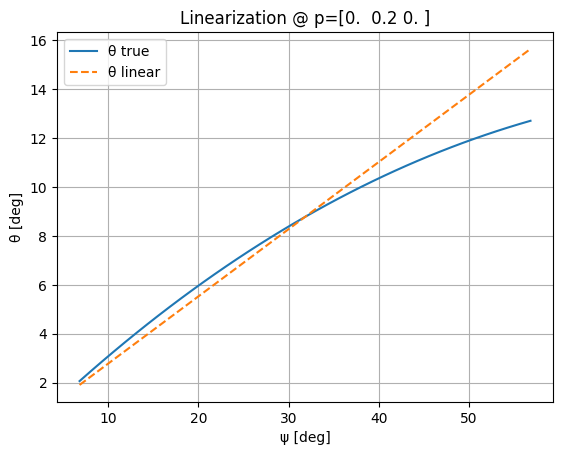

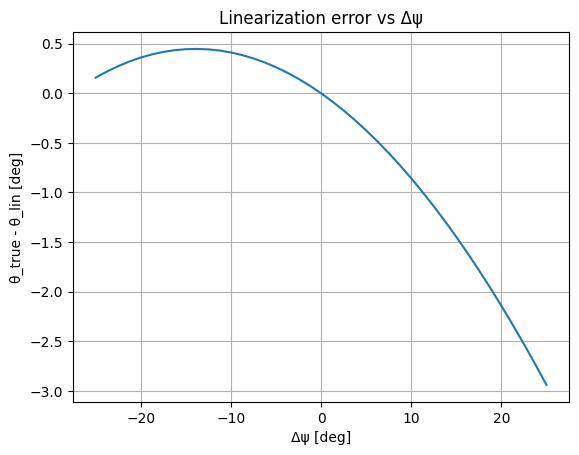

In [ ]:
k = -1
psi_before_deg = out["psi_deg"][k] - out["u_deg_s"][k]*dt
res = validate_linearization_at(psi_before_deg, p_vec=p_vec, dmax_deg=25.0, n_pts=41)


In [ ]:
p_vec = np.array([0.0, 0.19, 0.0])
A_deg = np.deg2rad(20)      
f_hz = 0.01   
offset_deg = np.deg2rad(0.0)  
phase_deg = 0.0  
T = 100.0          
dt = 10      
Np = 1 
ref = make_ref_sine(A_deg, f_hz, offset_deg, phase_deg)
t = np.arange(0.0, time+dt, dt)
theta = np.array([ref(test)[0] for test in t])
theta_dot = np.array([ref(test)[1] for test in t])

NameError: name 'np' is not defined

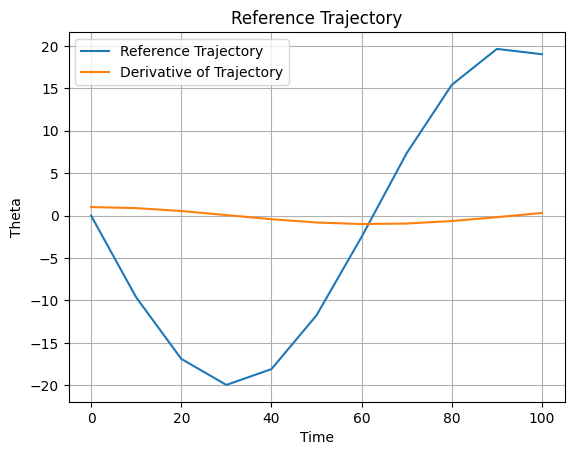

In [ ]:


plt.figure()
plt.plot(t, np.rad2deg(theta), label="Reference Trajectory")
plt.plot(t, np.rad2deg(theta_dot), label="Derivative of Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Reference Trajectory")
plt.legend()
plt.grid()
plt.show()

In [ ]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=10,
    w_th=100.0, w_u=1e-3, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_65643/535701994.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=22.53°  max|θ̂-R|=9.97°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        -1.09 |       -10.86 |      -10.83 |       -4.83 |       -9.64 |         +4.80
 2 |        -0.82 |       -19.05 |      -19.02 |       -8.46 |      -16.89 |         +8.43
 3 |        -0.35 |       -22.53 |      -22.50 |       -9.99 |      -19.96 |         +9.97
 4 |        +0.21 |       -20.42 |      -20.39 |       -9.06 |      -18.10 |         +9.03
 5 |        +0.72 |       -13.25 |      -13.23 |       -5.89 |      -11.76 |         +5.86
 6 |        +1.05 |        -2.80 |       -2.77 |       -1.27 |       -2.51 |         +1.24
 7 |        +1.12 |        +8.35 |       +8.38 |       +3.67 |       +7.36 |         -3.69
 8 |        +0.91 |       +17.44 |      +17.47 |       +7.69 |      +15.41 |         -7.72
 9 |        +0.48 |   

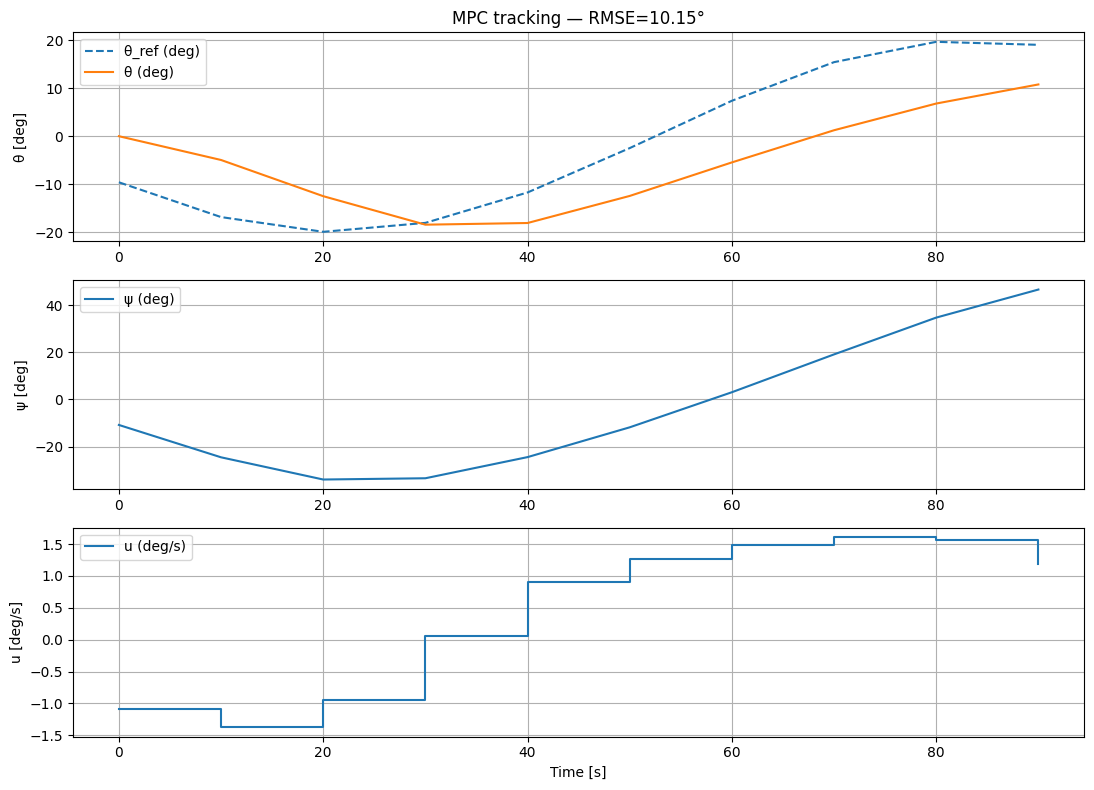

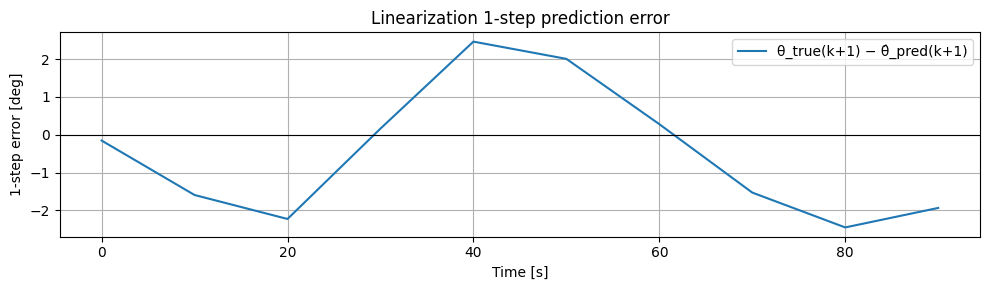

In [ ]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


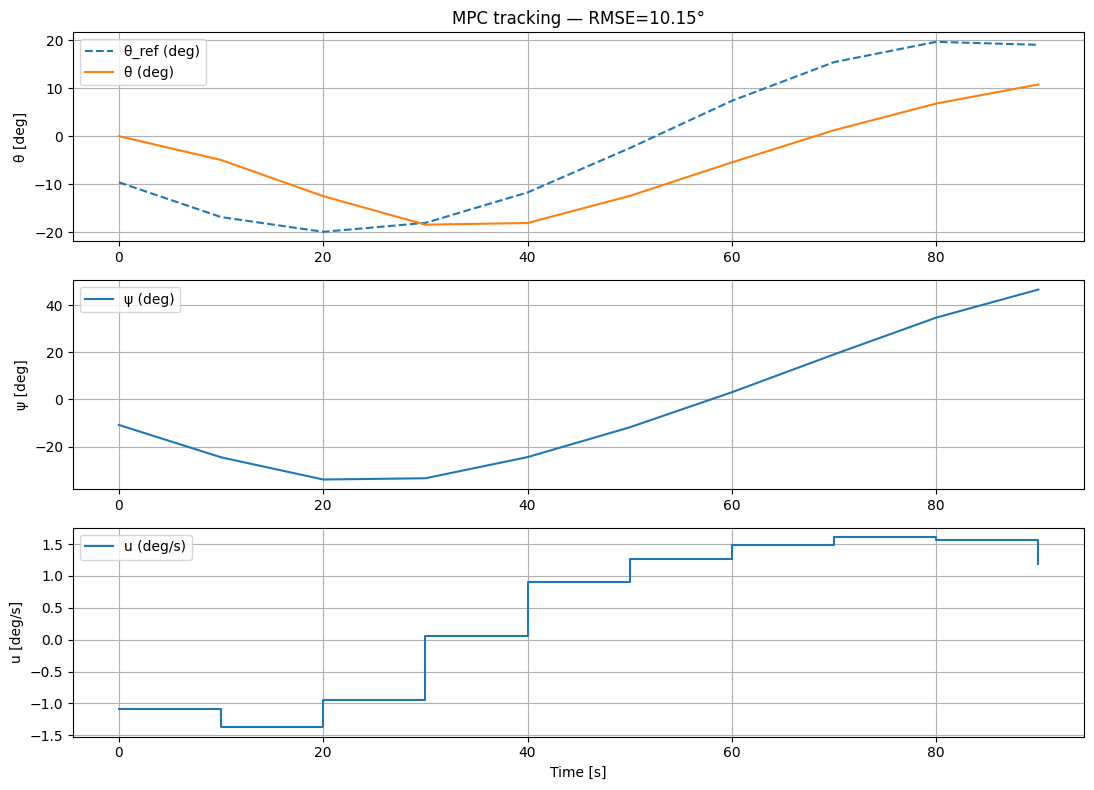

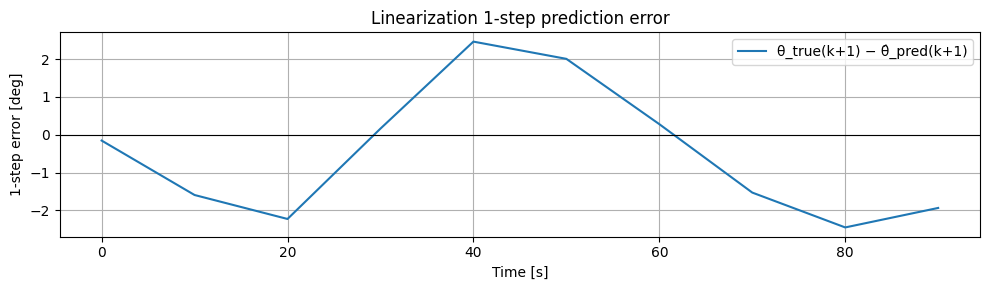

In [ ]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [ ]:

out = simple_mpc(
    ref, T, dt, p_vec,
    Np=10,
    w_th=100.0, w_u=1e-3, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_65643/535701994.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)



[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=13.52°  max|θ̂-R|=5.05°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        -0.61 |        -6.09 |       -6.06 |       -2.55 |       -4.82 |         +2.27
 2 |        -0.49 |       -10.95 |      -10.92 |       -4.36 |       -8.44 |         +4.09
 3 |        -0.21 |       -13.00 |      -12.98 |       -5.13 |       -9.98 |         +4.85
 4 |        +0.12 |       -11.76 |      -11.73 |       -4.66 |       -9.05 |         +4.39
 5 |        +0.42 |        -7.51 |       -7.48 |       -3.08 |       -5.88 |         +2.80
 6 |        +0.62 |        -1.31 |       -1.29 |       -0.76 |       -1.25 |         +0.49
 7 |        +0.66 |        +5.30 |       +5.32 |       +1.70 |       +3.68 |         -1.98
 8 |        +0.54 |       +10.69 |      +10.72 |       +3.72 |       +7.71 |         -3.99
 9 |        +0.28 |   

KeyboardInterrupt: 

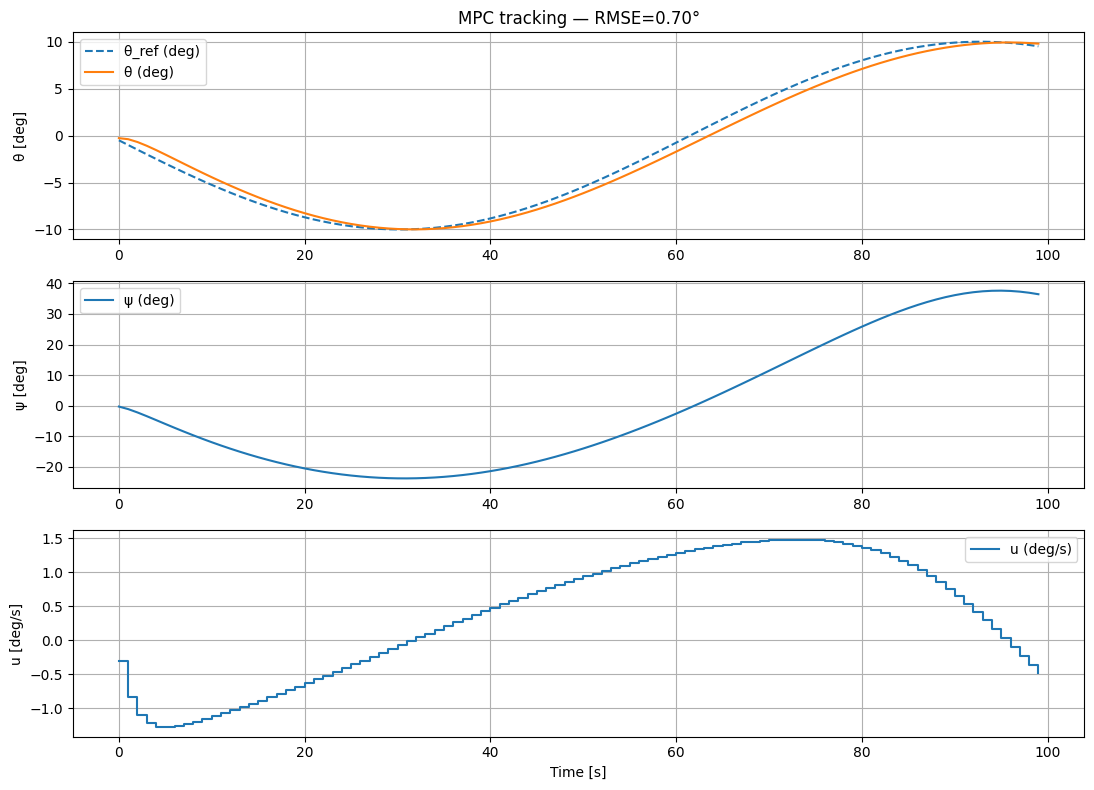

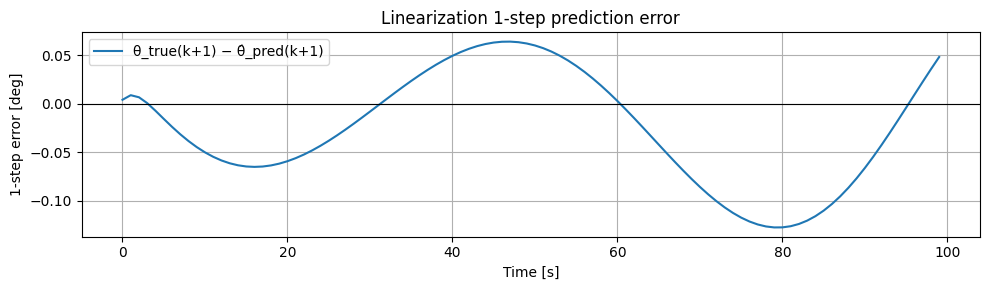

In [ ]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()
